# 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')


# 한글 폰트 설정
plt.rc('font', family='Liberation Mono')  # 윈도우에서 '맑은 고딕' 사용
# macOS에서는 'AppleGothic'을 사용
# plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시되게

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dartb/train.csv')

In [ ]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [ ]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


# 결측치 처리

In [ ]:
# 대출 금액 결측행 삭제
train = train.dropna(subset = ['LoanAmount'])

In [ ]:
# 1. LoanAmount를 기준으로 대출 금액대 그룹 만들기 (4개 그룹으로 나눔)
train["LoanAmount_Group"] = pd.qcut(train["LoanAmount"], q=4, labels=False)

# 2. 결측치 보간 전 데이터 백업 (변경된 값 비교용)
before_fill = train.copy()

# 3. 그룹 내 최빈값으로 보간하는 함수 (최빈값이 없는 경우 예외 처리 추가)
def fill_missing_by_group(df, group_col, target_col):
    # 그룹별 최빈값 계산
    mode_per_group = df.groupby(group_col)[target_col].apply(lambda x: x.mode().dropna().iloc[0] if not x.mode().dropna().empty else np.nan)

    # 결측치 대체
    df[target_col] = df[target_col].fillna(df[group_col].map(mode_per_group))

# 4. 결측치가 있는 'LoanAmount_Group' 처리 (그룹화 시 결측치를 제외하고 그룹화 후, 결측치는 임시로 -1로 설정)
train["LoanAmount_Group"].fillna(-1, inplace=True)

# 5. Gender, Dependents, Married 결측치 보간
for col in ["Gender", "Dependents", "Married"]:
    fill_missing_by_group(train, "LoanAmount_Group", col)

# 6. LoanAmount 그룹별 변경된 값 개수 확인
for col in ["Gender", "Dependents", "Married"]:
    changes = train[col] != before_fill[col]  # 변경된 값 찾기
    print(f"\n🔹 {col} 변경된 값 개수 (LoanAmount_Group 기준)")
    print(train.loc[changes, ["LoanAmount_Group", col]].value_counts().sort_index())

# 7. LoanAmount 그룹 기준 변경된 값 목록 출력
for col in ["Gender", "Dependents", "Married"]:
    changes = train[col] != before_fill[col]
    print(f"\n🔹 {col} 변경된 값 목록 (LoanAmount_Group 기준)")
    print(train.loc[changes, ["LoanAmount_Group", col, "LoanAmount"]].sort_values("LoanAmount_Group"))

# 8. 사용했던 그룹 컬럼 삭제
train.drop(columns=["LoanAmount_Group"], inplace=True)



🔹 Gender 변경된 값 개수 (LoanAmount_Group 기준)
LoanAmount_Group  Gender
0                 Male      2
1                 Male      2
2                 Male      5
3                 Male      4
Name: count, dtype: int64

🔹 Dependents 변경된 값 개수 (LoanAmount_Group 기준)
LoanAmount_Group  Dependents
0                 0             3
1                 0             3
2                 0             6
3                 0             1
Name: count, dtype: int64

🔹 Married 변경된 값 개수 (LoanAmount_Group 기준)
LoanAmount_Group  Married
2                 Yes        2
Name: count, dtype: int64

🔹 Gender 변경된 값 목록 (LoanAmount_Group 기준)
     LoanAmount_Group Gender  LoanAmount
588                 0   Male        94.0
507                 0   Male        96.0
23                  1   Male       112.0
467                 1   Male       110.0
460                 2   Male       160.0
477                 2   Male       132.0
314                 2   Male       159.0
188                 2   Male       168.0
576              

In [ ]:
train.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,31
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,14


In [ ]:
# train 남은 결측치에 최빈값 채우기
train["Self_Employed"].fillna(train["Self_Employed"].mode().iloc[0], inplace=True)
train["Loan_Amount_Term"].fillna(train["Loan_Amount_Term"].mode().iloc[0], inplace=True)

In [ ]:
train.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [ ]:
# 1. Loan_Status와 LoanAmount를 기준으로 Credit_History 결측치 보간하는 함수
def fill_credit_history_by_status_and_amount(df, status_col, amount_col, target_col):
    # Loan_Status와 LoanAmount의 구간을 기준으로 그룹화
    # LoanAmount는 qcut을 사용하여 구간으로 나눔 (4개 구간으로 나누기)
    df['LoanAmount_Group'] = pd.qcut(df[amount_col], q=4, labels=False)

    # 그룹별 최빈값 계산 (status_col: 'Loan_Status', amount_col: 'LoanAmount', target_col: 'Credit_History')
    mode_per_group = df.groupby([status_col, 'LoanAmount_Group'])[target_col].apply(lambda x: x.mode().dropna().iloc[0] if not x.mode().dropna().empty else np.nan)

    # 결측치 대체
    df[target_col] = df[target_col].fillna(df.apply(lambda row: mode_per_group.get((row[status_col], row['LoanAmount_Group']), np.nan), axis=1))

    # 사용한 그룹 컬럼 삭제
    df.drop(columns=['LoanAmount_Group'], inplace=True)

    return df

# 2. 결측치 보간 전 데이터 백업 (변경된 값 비교용)
before_fill_train = train.copy()

# 3. Loan_Status와 LoanAmount 기준으로 Credit_History 결측치 보간 (train_df 적용)
train_df = fill_credit_history_by_status_and_amount(train, "Loan_Status", "LoanAmount", "Credit_History")

# 4. 변경된 값 확인 (변경된 값 찾기)
changes_train = train["Credit_History"] != before_fill_train["Credit_History"]
print("\n🔹 Credit_History 변경된 값 개수 (Loan_Status + LoanAmount 기준) - train_df")
print(train.loc[changes_train, ["Loan_Status", "LoanAmount", "Credit_History"]].value_counts().sort_index())

# 5. 변경된 값 목록 출력
print("\n🔹 Credit_History 변경된 값 목록 (Loan_Status + LoanAmount 기준) - train_df")
print(train.loc[changes_train, ["Loan_Status", "LoanAmount", "Credit_History"]].sort_values("Loan_Status"))


🔹 Credit_History 변경된 값 개수 (Loan_Status + LoanAmount 기준) - train_df
Loan_Status  LoanAmount  Credit_History
N            61.0        1.0               1
             67.0        1.0               1
             128.0       0.0               1
             138.0       1.0               1
             151.0       1.0               1
             182.0       1.0               1
             190.0       1.0               1
             196.0       1.0               1
             201.0       1.0               1
             255.0       1.0               1
             265.0       1.0               1
             350.0       1.0               1
Y            58.0        1.0               1
             60.0        1.0               1
             75.0        1.0               1
             84.0        1.0               1
             85.0        1.0               1
             88.0        1.0               1
             93.0        1.0               2
             95.0        1.0         

# 인코딩 -> train_cleaned

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

train_cleaned = train.copy()

# 인코딩
for col in ["Gender", "Married", "Dependents", "Self_Employed", "Loan_Amount_Term", "Loan_Status"]:
    train_cleaned[col].fillna(train_cleaned[col].mode()[0], inplace=True)
train_cleaned["Credit_History"].fillna(train_cleaned["Credit_History"].mode()[0], inplace=True)
train_cleaned["LoanAmount"].fillna(train_cleaned["LoanAmount"].median(), inplace=True)

# 라벨 인코딩할 순서형 변수들
label_enc_cols = ["Credit_History", "Loan_Amount_Term", "Loan_Status"]
label_encoders = {}

for col in label_enc_cols:
    le = LabelEncoder()
    train_cleaned[col] = le.fit_transform(train_cleaned[col])
    label_encoders[col] = le

# 원-핫 인코딩할 변수들
one_hot_cols = ["Gender", "Married", "Education", "Self_Employed", "Property_Area"]
train_cleaned = pd.get_dummies(train_cleaned, columns=one_hot_cols, drop_first=True)

# 결과 출력
print(train_cleaned.head())


    Loan_ID Dependents  ApplicantIncome  CoapplicantIncome  LoanAmount  \
1  LP001003          1             4583             1508.0       128.0   
2  LP001005          0             3000                0.0        66.0   
3  LP001006          0             2583             2358.0       120.0   
4  LP001008          0             6000                0.0       141.0   
5  LP001011          2             5417             4196.0       267.0   

   Loan_Amount_Term  Credit_History  Loan_Status  Gender_Male  Married_Yes  \
1                 8               1            0         True         True   
2                 8               1            1         True         True   
3                 8               1            1         True         True   
4                 8               1            1         True        False   
5                 8               1            1         True         True   

   Education_Not Graduate  Self_Employed_Yes  Property_Area_Semiurban  \
1            

In [ ]:
train_cleaned

,Loan_ID,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
1,LP001003,1,4583,1508.0,128.0,8,1,0,True,True,False,False,False,False
2,LP001005,0,3000,0.0,66.0,8,1,1,True,True,False,True,False,True
3,LP001006,0,2583,2358.0,120.0,8,1,1,True,True,True,False,False,True
4,LP001008,0,6000,0.0,141.0,8,1,1,True,False,False,False,False,True
5,LP001011,2,5417,4196.0,267.0,8,1,1,True,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,2900,0.0,71.0,8,1,1,False,False,False,False,False,False
610,LP002979,3+,4106,0.0,40.0,5,1,1,True,True,False,False,False,False
611,LP002983,1,8072,240.0,253.0,8,1,1,True,True,False,False,False,True
612,LP002984,2,7583,0.0,187.0,8,1,1,True,True,False,False,False,True


In [ ]:
train.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


# 새로운 변수 생성

In [ ]:
train_cleaned["TotalIncome"] = train_cleaned["ApplicantIncome"] + train_cleaned["CoapplicantIncome"]
train_cleaned["Income_to_Loan_Ratio"] = train_cleaned["TotalIncome"] / train_cleaned["LoanAmount"]

In [ ]:
train["TotalIncome"] = train["ApplicantIncome"] + train["CoapplicantIncome"]
train["Income_to_Loan_Ratio"] = train["TotalIncome"] / train["LoanAmount"]

# EDA

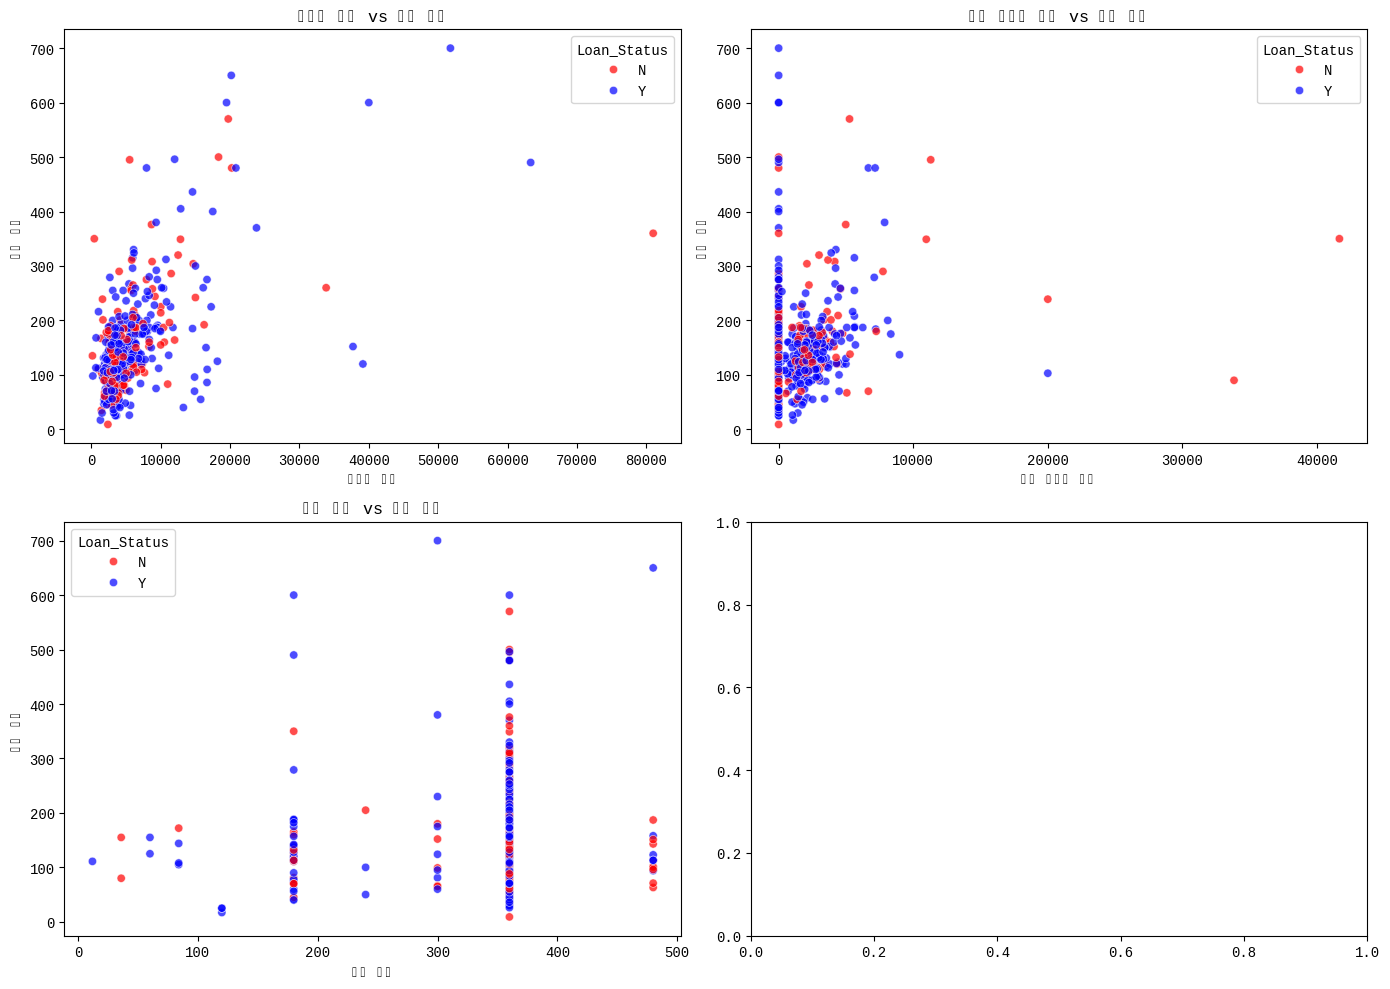

In [ ]:
#수치형 변수들과 대출금액 -> 대출 승인 상태별로 산점도
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 신청자 소득 vs 대출 금액
sns.scatterplot(data=train, x='ApplicantIncome', y='LoanAmount', hue='Loan_Status',
                palette={'Y': 'blue', 'N': 'red'}, alpha=0.7, ax=axes[0, 0])
axes[0, 0].set_title('신청자 소득 vs 대출 금액')
axes[0, 0].set_xlabel('신청자 소득')
axes[0, 0].set_ylabel('대출 금액')

# 공동 신청자 소득 vs 대출 금액
sns.scatterplot(data=train, x='CoapplicantIncome', y='LoanAmount', hue='Loan_Status',
                palette={'Y': 'blue', 'N': 'red'}, alpha=0.7, ax=axes[0, 1])
axes[0, 1].set_title('공동 신청자 소득 vs 대출 금액')
axes[0, 1].set_xlabel('공동 신청자 소득')
axes[0, 1].set_ylabel('대출 금액')

# 대출 기간 vs 대출 금액
sns.scatterplot(data=train, x='Loan_Amount_Term', y='LoanAmount', hue='Loan_Status',
                palette={'Y': 'blue', 'N': 'red'}, alpha=0.7, ax=axes[1, 0])
axes[1, 0].set_title('대출 기간 vs 대출 금액')
axes[1, 0].set_xlabel('대출 기간')
axes[1, 0].set_ylabel('대출 금액')

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()

In [ ]:
result = train.groupby('Gender')['LoanAmount'].mean()
print(result)

Gender
Female    126.697248
Male      150.861284
Name: LoanAmount, dtype: float64


In [ ]:
result = train.groupby('Gender')['Loan_Amount_Term'].mean()
print(result)

Gender
Female    353.394495
Male      340.124224
Name: Loan_Amount_Term, dtype: float64


In [ ]:
result = train.groupby('Gender')['Loan_Status'].value_counts()
print(result)

Gender  Loan_Status
Female  Y               73
        N               36
Male    Y              338
        N              145
Name: count, dtype: int64


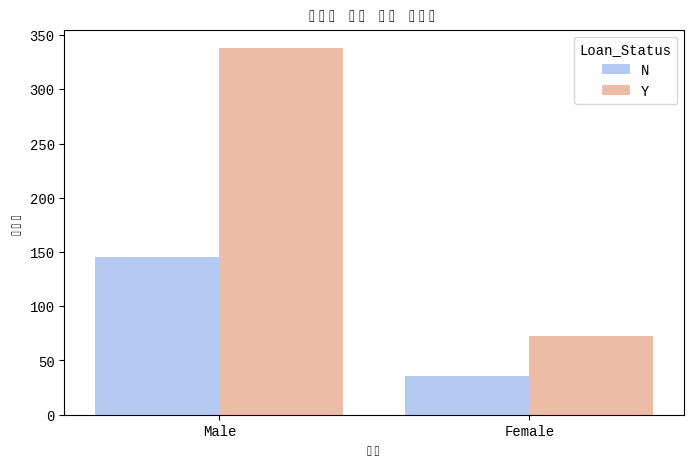

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', hue='Loan_Status', data=train, palette='coolwarm')
plt.title('성별에 따른 대출 승인율')
plt.xlabel('성별')
plt.ylabel('인원수')
plt.show()

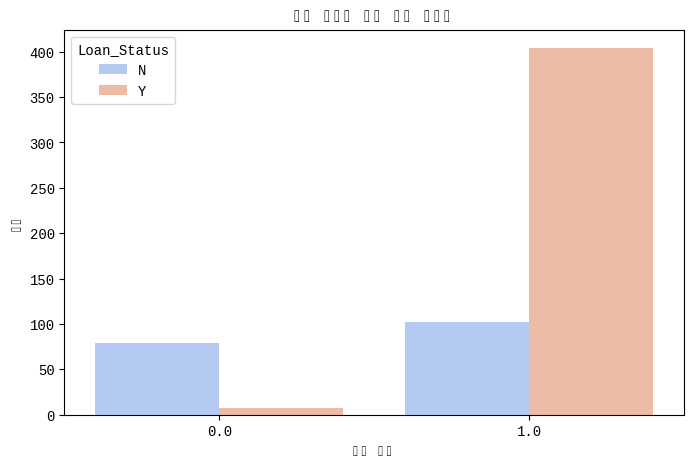

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Credit_History', hue='Loan_Status', data=train, palette='coolwarm')
plt.title('신용 이력에 따른 대출 승인율')
plt.xlabel('신용 이력')
plt.ylabel('갯수')
plt.show()

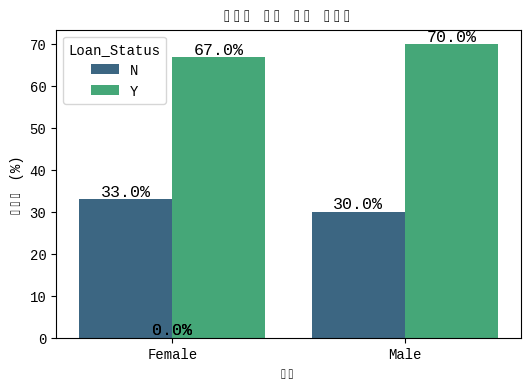

In [ ]:
category = 'Gender'  # 그룹화할 기준 칼럼 (예: Gender)
target = 'Loan_Status'  # 시각화할 대상 칼럼 (예: Loan_Status)

# 각 그룹별로 100% 기준으로 비율 계산
grouped_df = train.groupby([category, target]).size().unstack().fillna(0)
grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0) * 100  # 각 그룹별로 100%로 변환

# 데이터 변형을 다시 원래 형태로
grouped_df = grouped_df.reset_index().melt(id_vars=[category], var_name=target, value_name='Percentage')

# 백분율 기준으로 countplot 그리기
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=category, y="Percentage", hue=target, data=grouped_df, palette="viridis")

# 막대 위에 백분율 표시
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=12)

plt.title('성별에 따른 대출 승인율')
plt.ylabel('퍼센트 (%)')
plt.xlabel('성별')
plt.show()

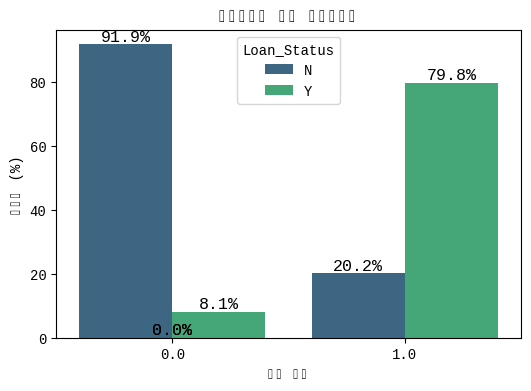

In [ ]:
category = 'Credit_History'  # 그룹화할 기준 칼럼
target = 'Loan_Status'  # 시각화할 대상 칼럼

# 각 그룹별로 100% 기준으로 비율 계산
grouped_df = train.groupby([category, target]).size().unstack().fillna(0)
grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0) * 100  # 각 그룹별 100%로 변환

# 데이터 변형을 다시 원래 형태로
grouped_df = grouped_df.reset_index().melt(id_vars=[category], var_name=target, value_name='Percentage')

# 백분율 기준으로 countplot 그리기
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=category, y="Percentage", hue=target, data=grouped_df, palette="viridis")

# 막대 위에 백분율 표시
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=12)

plt.title('신용이력에 따른 대출승인율')
plt.ylabel('퍼센트 (%)')
plt.xlabel('신용 이력')
plt.show()

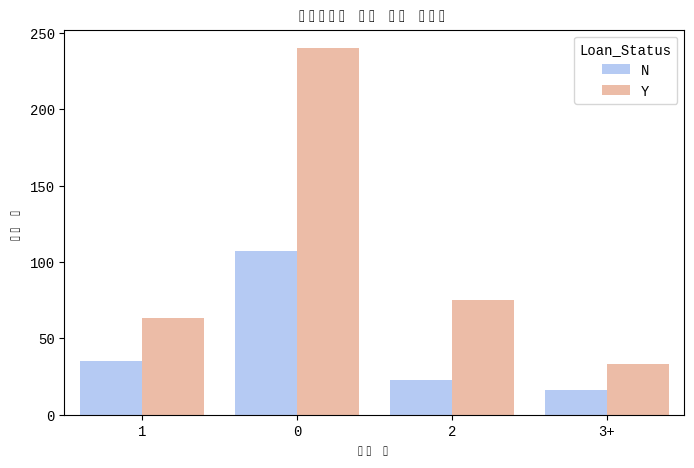

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Dependents', hue='Loan_Status', data=train, palette='coolwarm')
plt.title('부양가족에 따른 대출 승인율')
plt.xlabel('가족 수')
plt.ylabel('전체 수')
plt.show()

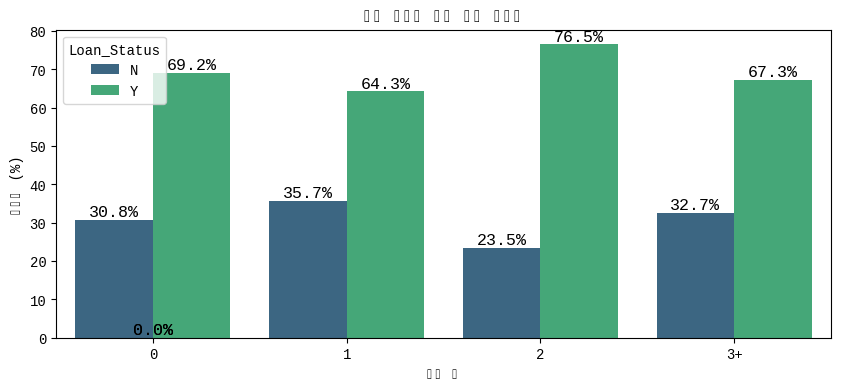

In [ ]:
category = 'Dependents'  # 그룹화할 기준 칼럼
target = 'Loan_Status'  # 시각화할 대상 칼럼

# 각 그룹별로 100% 기준으로 비율 계산
grouped_df = train.groupby([category, target]).size().unstack().fillna(0)
grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0) * 100  # 각 그룹별 100%로 변환

# 데이터 변형을 다시 원래 형태로
grouped_df = grouped_df.reset_index().melt(id_vars=[category], var_name=target, value_name='Percentage')

# 백분율 기준으로 countplot 그리기
plt.figure(figsize=(10, 4))
ax = sns.barplot(x=category, y="Percentage", hue=target, data=grouped_df, palette="viridis")

# 막대 위에 백분율 표시
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=12)

plt.title('부양 가족에 따른 대출 승인율')
plt.ylabel('퍼센트 (%)')
plt.xlabel('가족 수')
plt.show()

Shape of the dataset: (592, 15)

Column names:
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'TotalIncome', 'Income_to_Loan_Ratio'],
      dtype='object')

Data types of each column:
Loan_ID                  object
Gender                   object
Married                  object
Dependents               object
Education                object
Self_Employed            object
ApplicantIncome           int64
CoapplicantIncome       float64
LoanAmount              float64
Loan_Amount_Term        float64
Credit_History          float64
Property_Area            object
Loan_Status              object
TotalIncome             float64
Income_to_Loan_Ratio    float64
dtype: object

Missing values in each column:
Loan_ID                 0
Gender                  0
Married                 0
Dependents              0
Educa

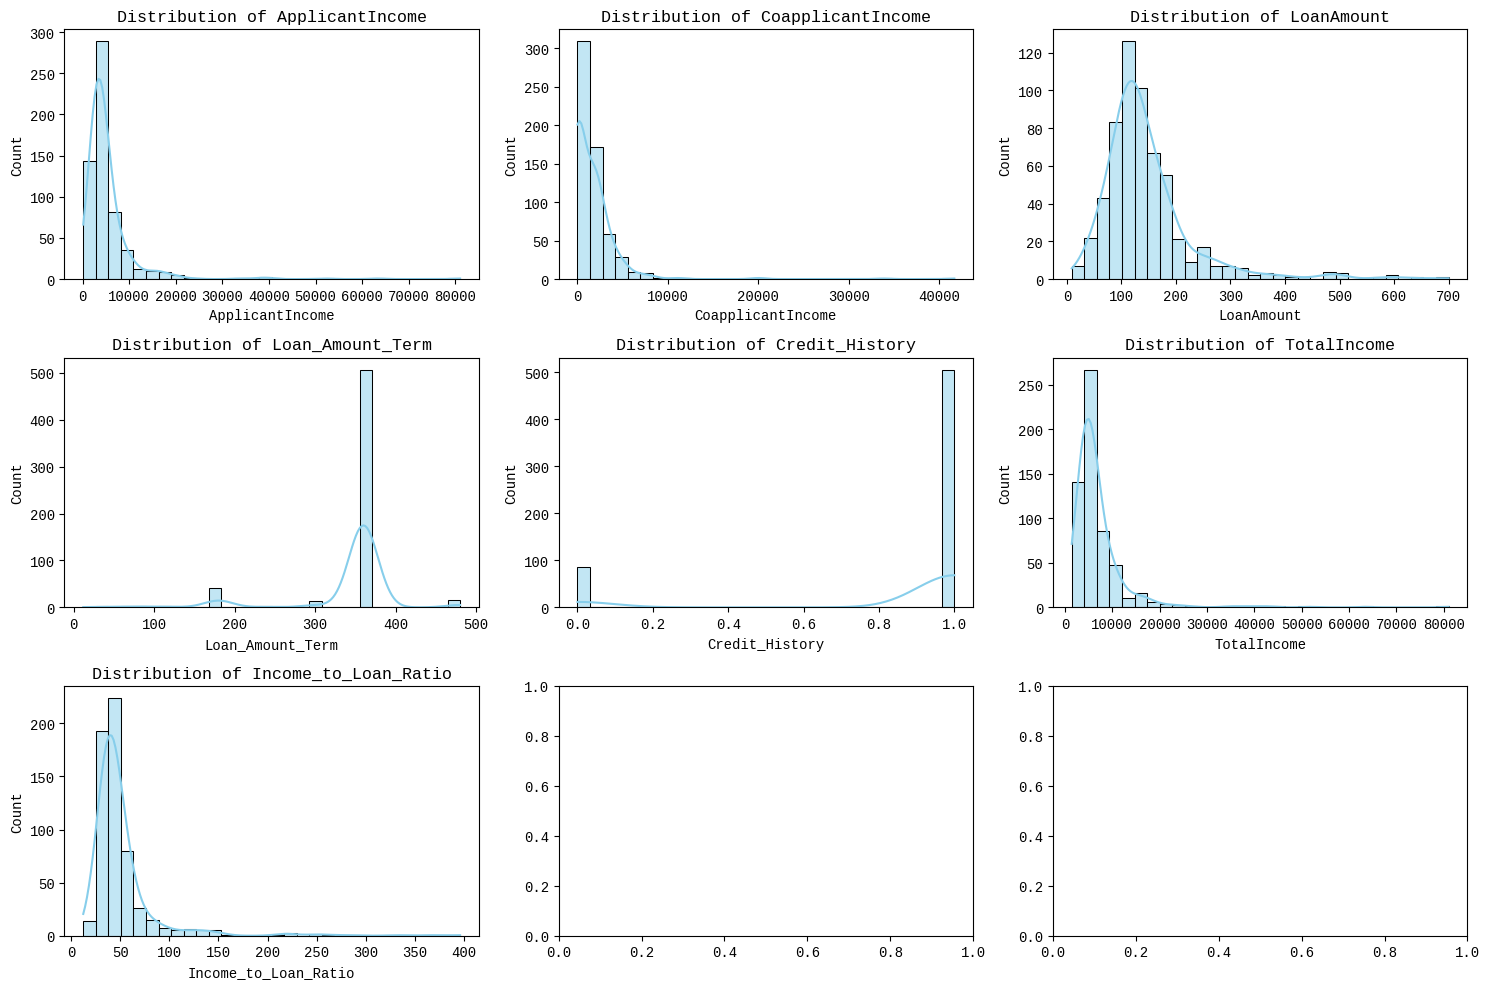

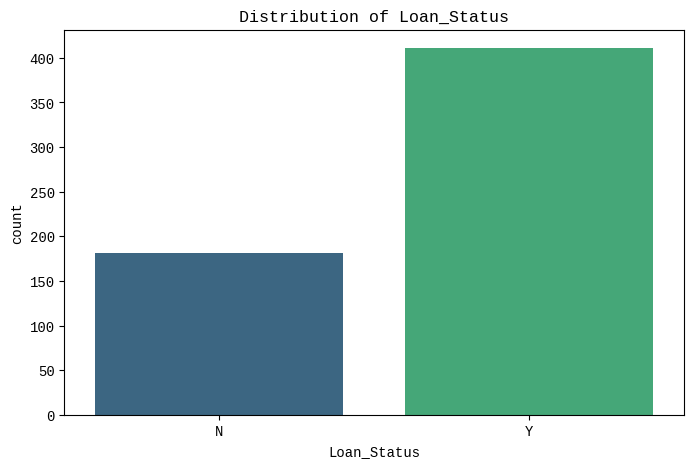

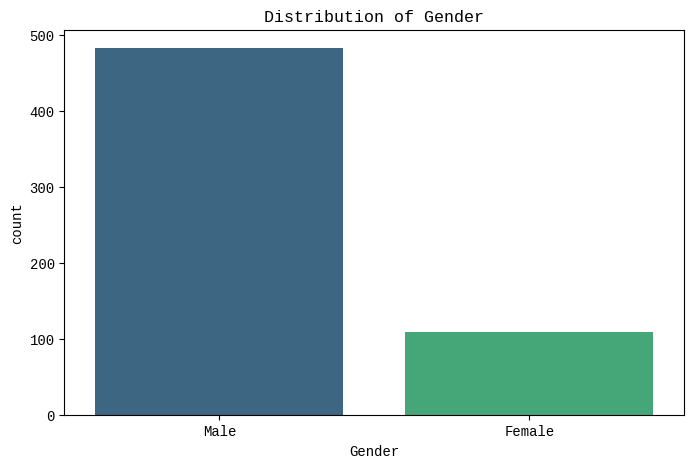

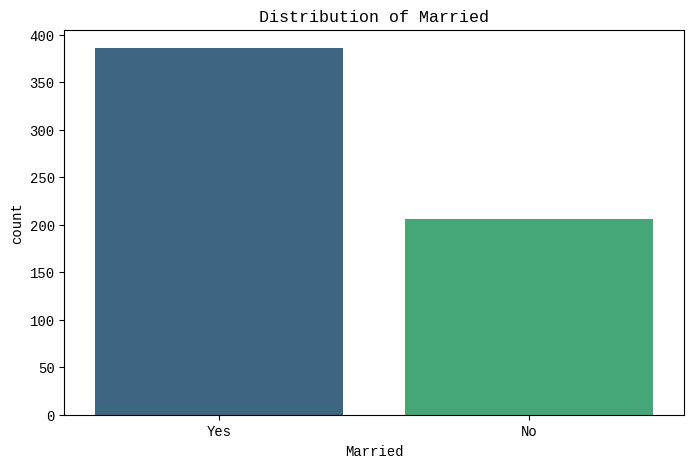

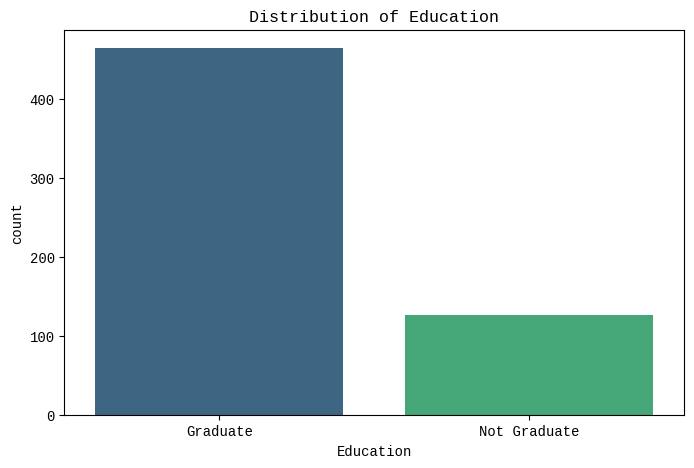

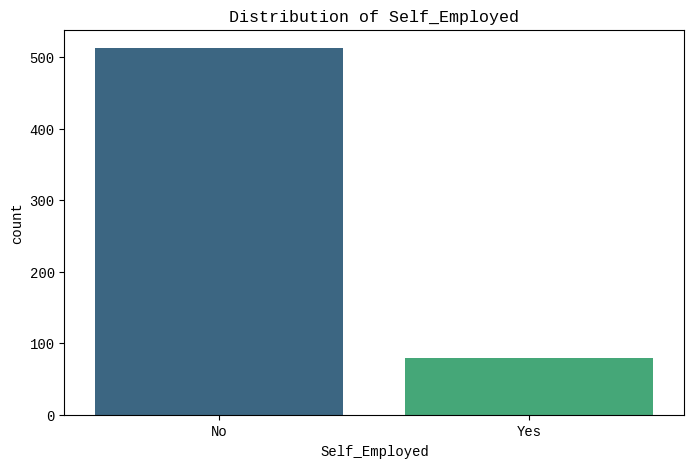

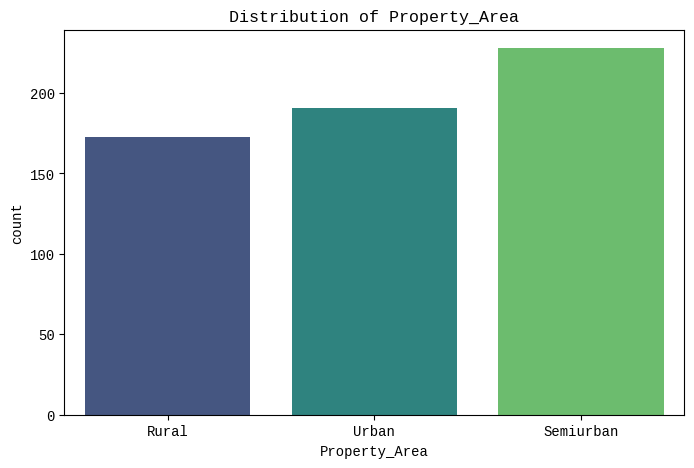

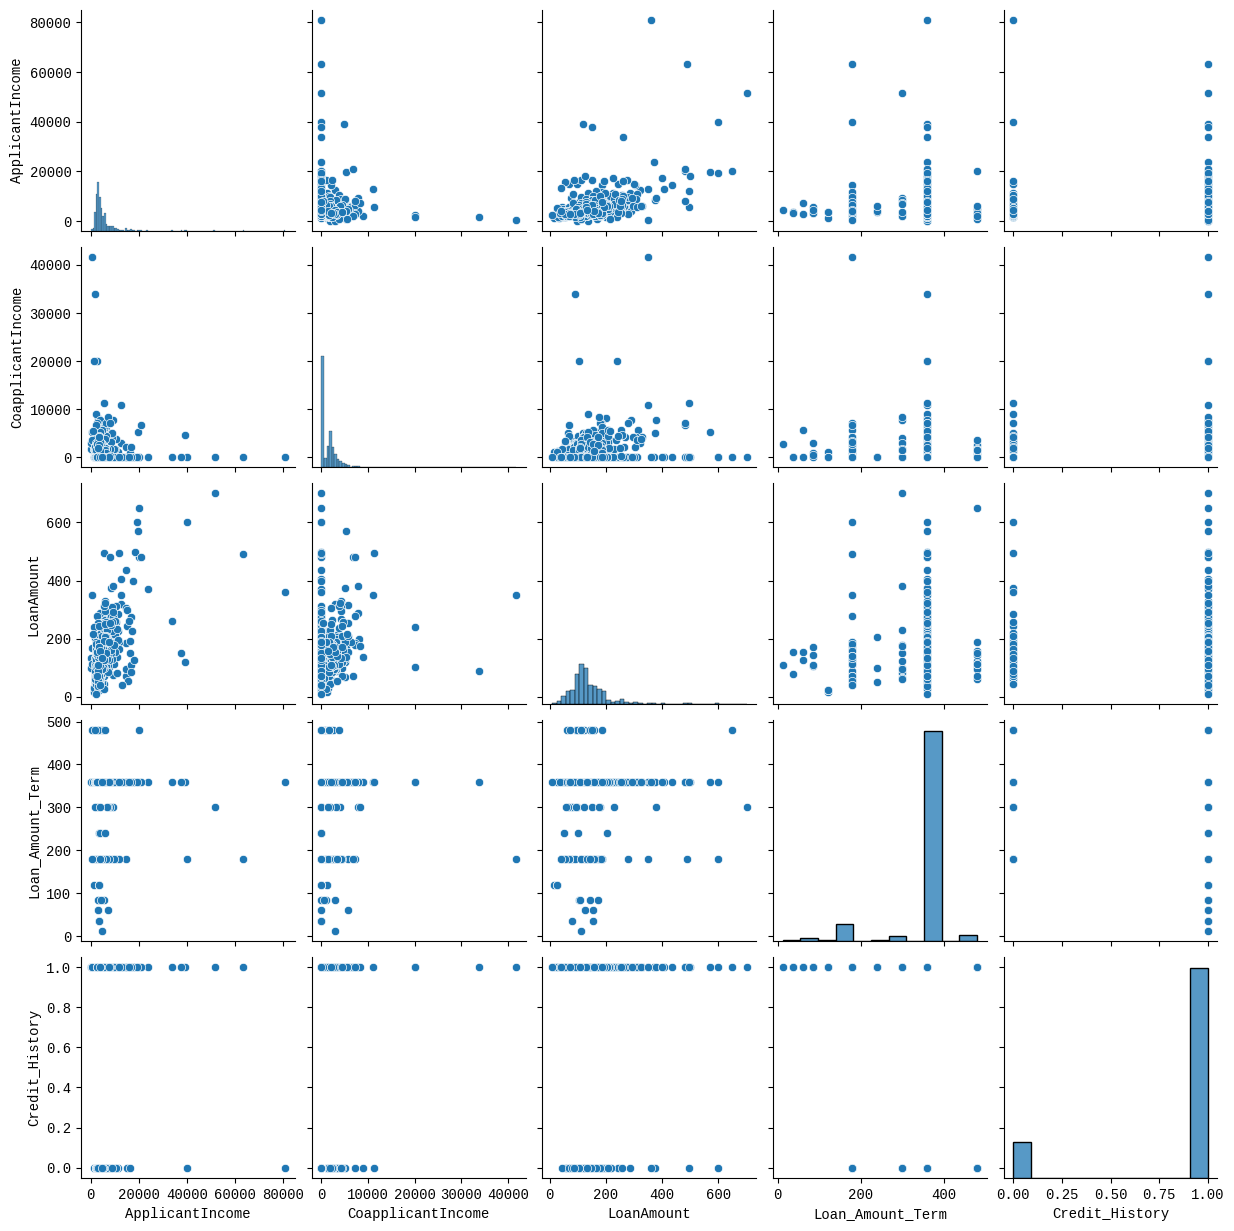

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터셋 기본 정보 확인
def basic_info(df):
    print("Shape of the dataset:", df.shape)
    print("\nColumn names:")
    print(df.columns)
    print("\nData types of each column:")
    print(df.dtypes)
    print("\nMissing values in each column:")
    print(df.isnull().sum())
    print("\nBasic statistical summary:")
    print(df.describe())

# 각 컬럼의 분포 시각화 (연속형 변수)
def plot_distributions(df):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # 서브플롯 생성
    axes = axes.flatten()  # 2D -> 1D 변환
    numeric_cols = df.select_dtypes(include=['number']).columns  # 수치형 컬럼만 선택

    for i, col in enumerate(numeric_cols[:len(axes)]):  # 최대 서브플롯 개수만큼 반복
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f"Distribution of {col}")

    plt.tight_layout()  # 그래프 간격 자동 조정
    plt.show()

# 범주형 변수 분포 시각화
def categorical_distribution(df, categorical_cols):
    for col in categorical_cols:
        if col in df.columns:  # 해당 컬럼이 존재하는지 확인
            plt.figure(figsize=(8, 5))
            sns.countplot(data=df, x=col, palette='viridis')
            plt.title(f"Distribution of {col}")
            plt.show()
        else:
            print(f"Column '{col}' not found in DataFrame. Skipping...")

# 수치형 변수 간 관계 시각화 (Pairplot)
def numerical_relationship(df, num_cols):
    sns.pairplot(df[num_cols])
    plt.show()  # suptitle 제거하여 겹치는 문제 해결

# 범주형 변수 리스트
categorical_cols = ['Loan_Status', 'Gender', 'Married', 'Education',
                    'Self_Employed', 'Property_Area']

# 수치형 변수 리스트
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
            'Loan_Amount_Term', 'Credit_History', 'Dependents']

# EDA 실행
basic_info(train)
plot_distributions(train)  # 연속형 변수 분포 확인
categorical_distribution(train, categorical_cols)  # 범주형 변수 분포 확인
numerical_relationship(train, num_cols)  # 수치형 변수 간 관계 확인


In [ ]:
train.groupby('Gender')['LoanAmount'].mean()

,LoanAmount
Gender,
Female,126.697248
Male,150.861284


In [ ]:
train.groupby('Loan_Status')['LoanAmount'].mean()

,LoanAmount
Loan_Status,
N,151.220994
Y,144.294404


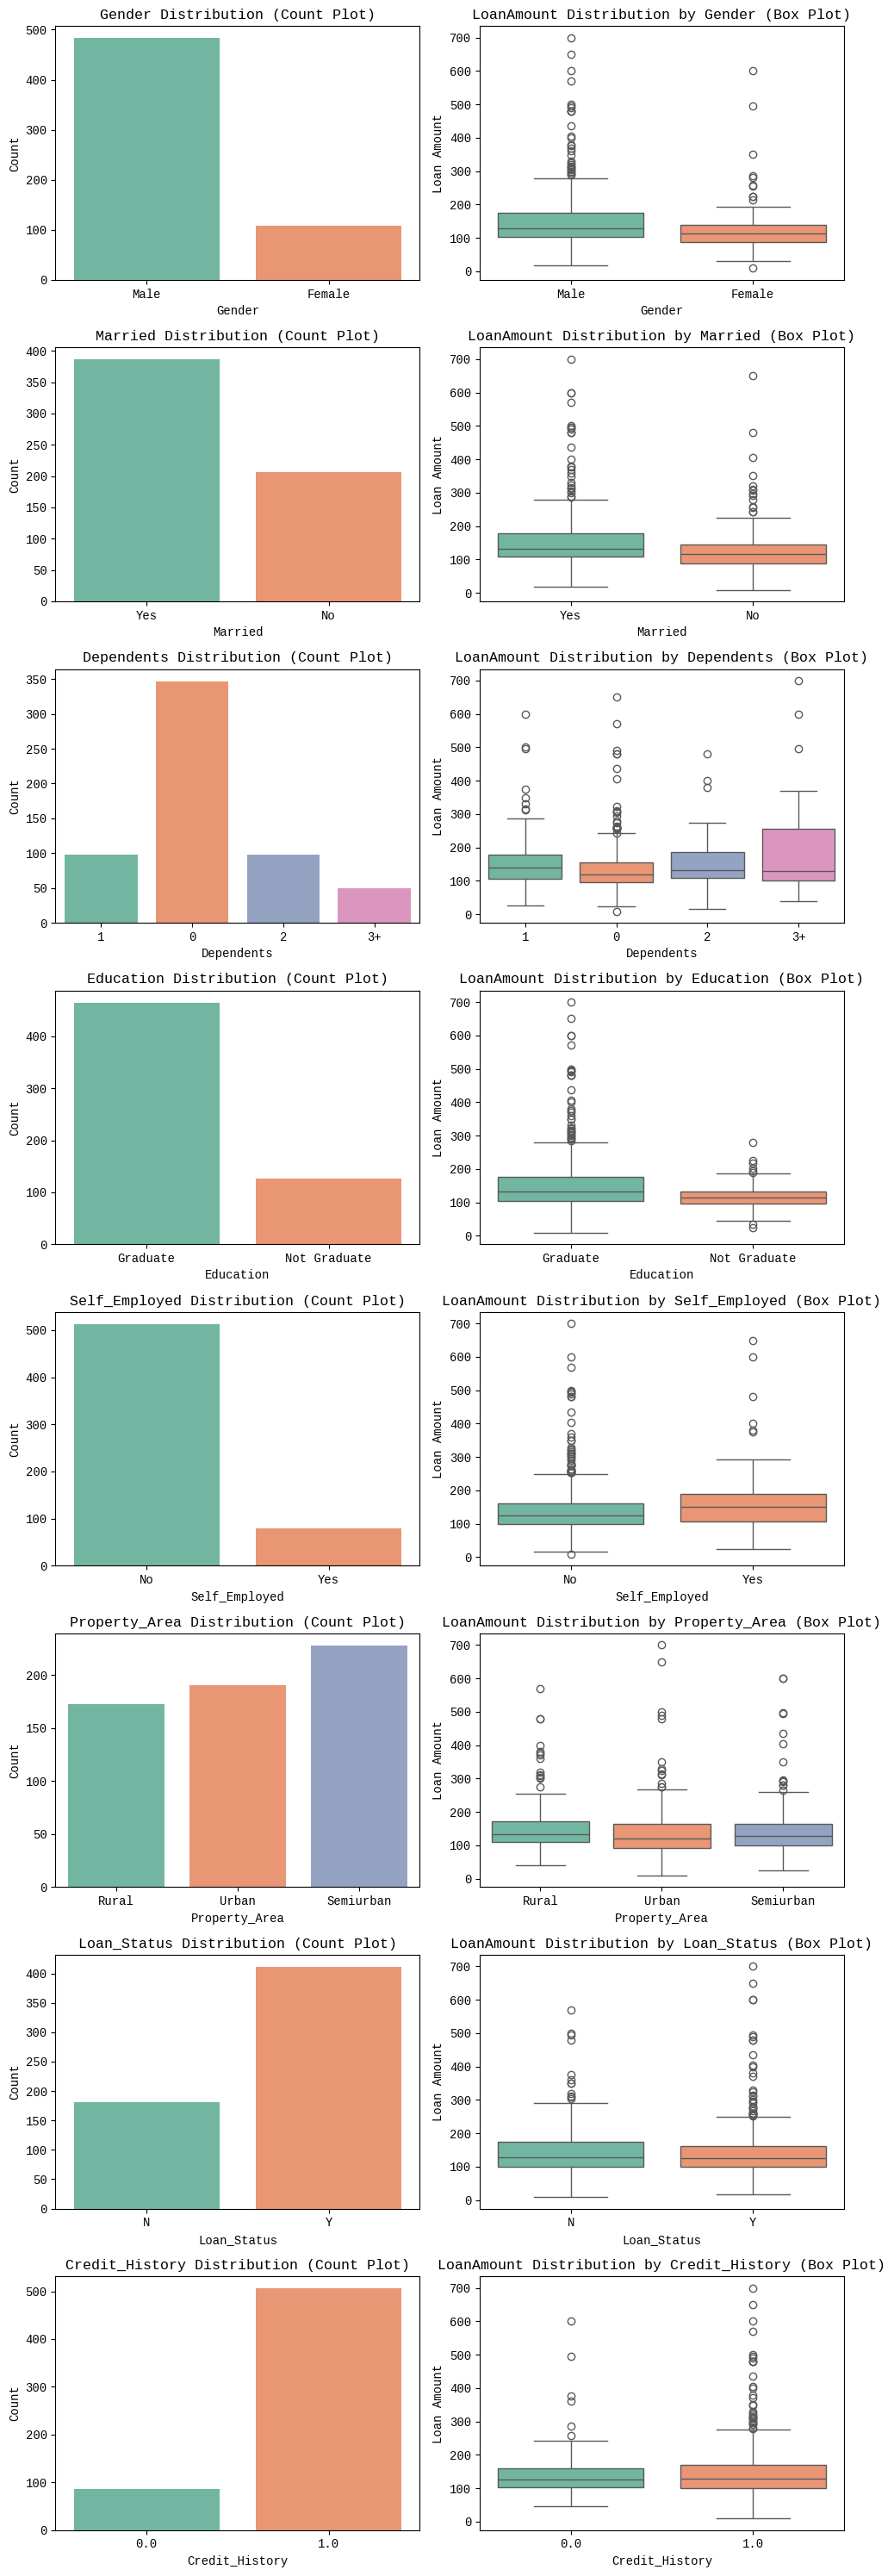

In [ ]:
# 변수 값 분포 확인 + 변수 값별로 대출 금액 박스플롯

# 범주형 열들 찾기
categorical_columns = train.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop('Loan_ID')  # 'Loan_Status' 열 제외
categorical_columns = categorical_columns.append(pd.Index(['Credit_History']))

# 그래프 크기 설정
plt.figure(figsize=(10, 30))

# 범주형 열들에 대해 반복문 실행
for i, col in enumerate(categorical_columns):
    # 첫 번째 서브플롯 설정 (막대그래프)
    plt.subplot(len(categorical_columns), 2, 2*i+1)  # (n, 2)는 두 개씩 나열
    sns.countplot(data=train, x=col, palette='Set2')
    plt.title(f'{col} Distribution (Count Plot)')
    plt.xlabel(col)
    plt.ylabel('Count')

    # 두 번째 서브플롯 설정 (박스 플롯)
    plt.subplot(len(categorical_columns), 2, 2*i+2)
    sns.boxplot(data=train, x=col, y='LoanAmount', palette='Set2')
    plt.title(f'LoanAmount Distribution by {col} (Box Plot)')
    plt.xlabel(col)
    plt.ylabel('Loan Amount')

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()

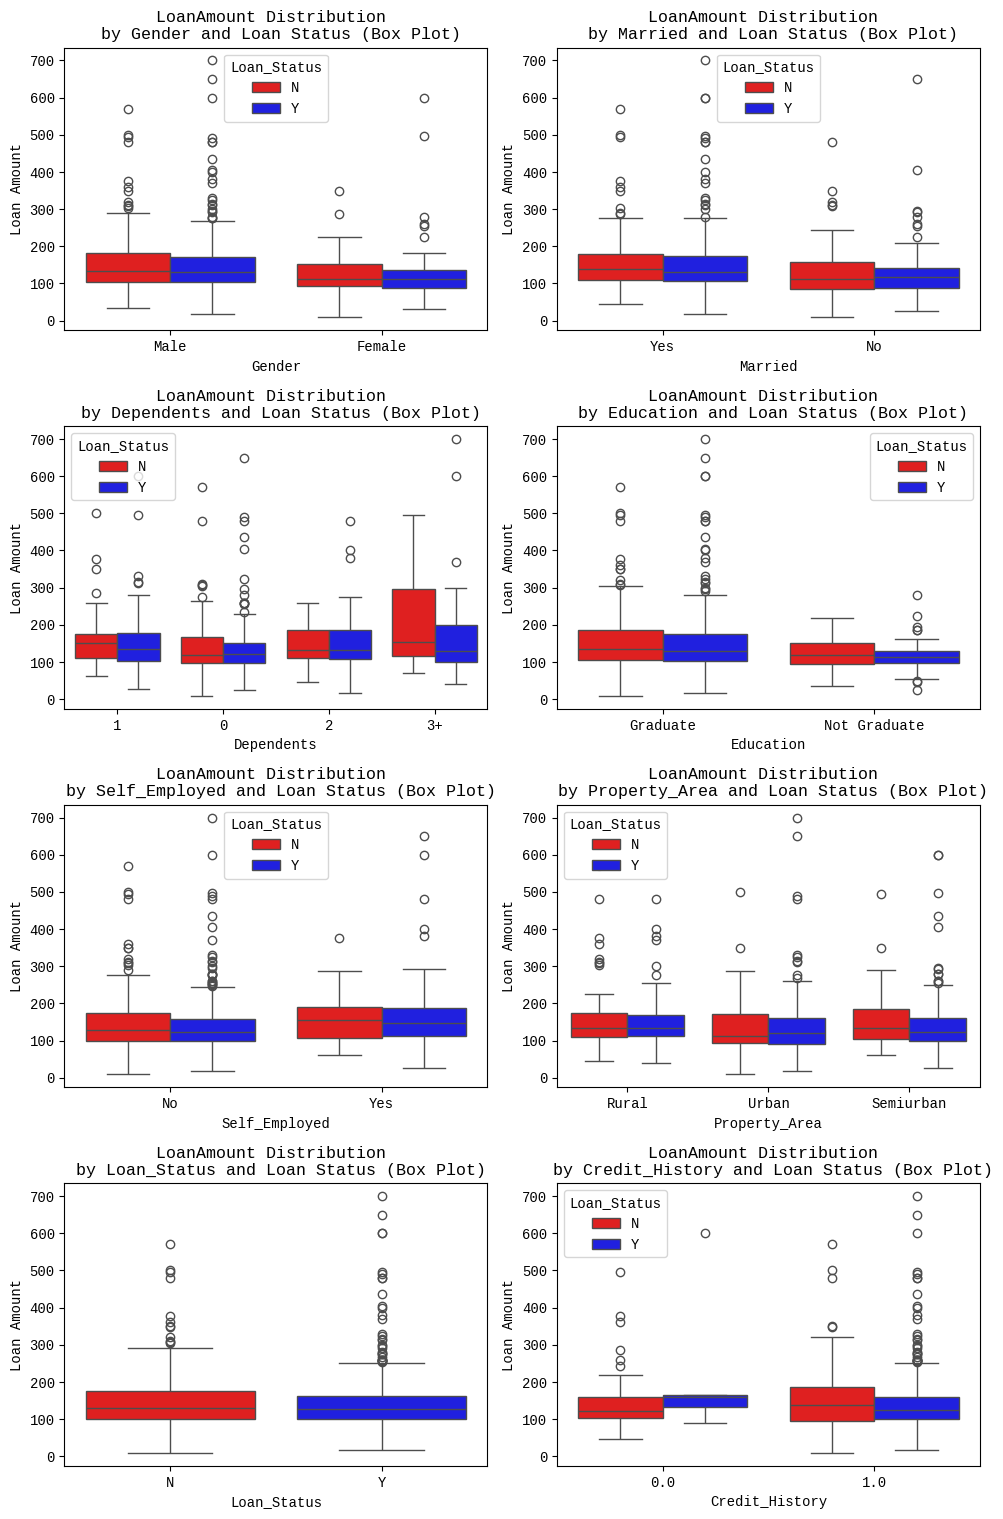

In [ ]:
# 변수 값별 + 대출승인 상태별 대출금액 박스플롯
plt.figure(figsize=(10, 30))

num_rows = len(categorical_columns)  # Total number of categories
num_cols = 2  # Number of columns in the subplot grid

for i, col in enumerate(categorical_columns):
    # Calculate the subplot index correctly within the grid
    subplot_index = i + 1

    plt.subplot(num_rows, num_cols, subplot_index)  # Specify grid layout and index
    sns.boxplot(data=train, x=col, y='LoanAmount', hue='Loan_Status', palette={'Y': 'blue', 'N': 'red'})
    plt.title(f'LoanAmount Distribution \n by {col} and Loan Status (Box Plot)')
    plt.xlabel(col)
    plt.ylabel('Loan Amount')

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()

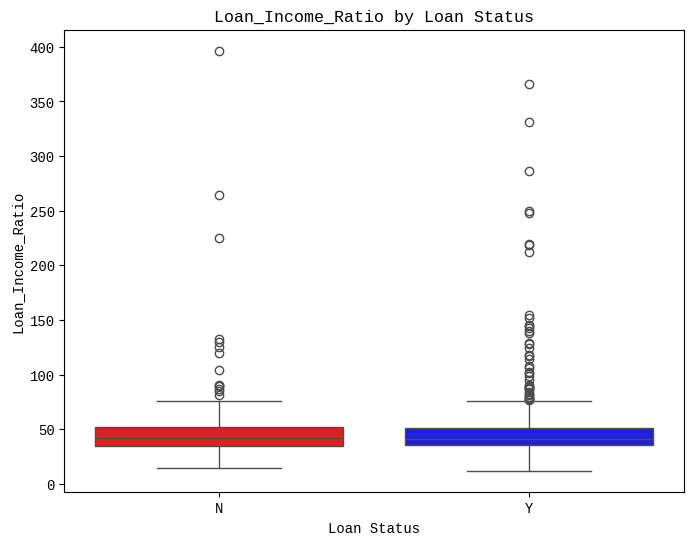

In [ ]:
#TotalIncome/LoanAmount

plt.figure(figsize=(8, 6))
sns.boxplot(data=train, x='Loan_Status', y='Income_to_Loan_Ratio', palette={'Y': 'blue', 'N': 'red'})

plt.title('Loan_Income_Ratio by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan_Income_Ratio')
plt.show()

In [ ]:
train.groupby('Loan_Status')[['Income_to_Loan_Ratio']].describe()

Income_to_Loan_Ratio                                              \
                           count       mean        std        min        25%   
Loan_Status                                                                    
N                          181.0  49.842321  38.449173  14.444444  34.645669   
Y                          411.0  51.835087  37.710840  12.090196  35.598611   

                                               
                   50%        75%         max  
Loan_Status                                    
N            41.938312  51.848889  396.366667  
Y            41.175000  51.631357  365.808333

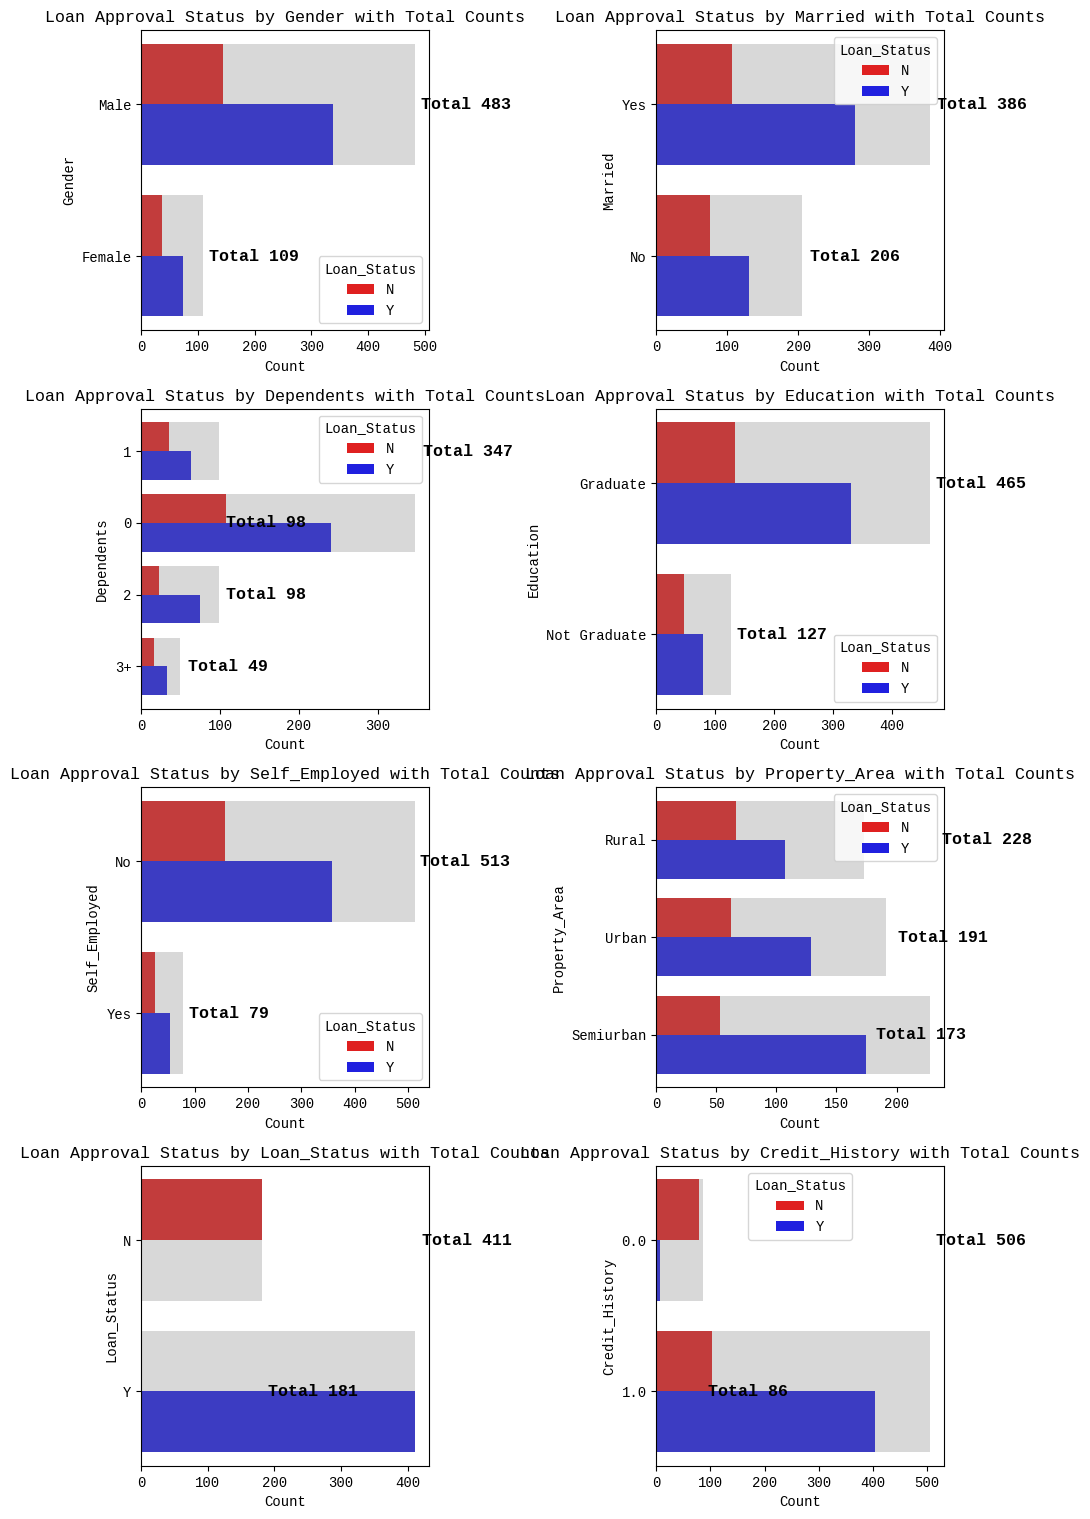

In [ ]:
# 변수 값별로 대출승인상태 막대그래프

# 전체 그래프의 크기 설정
plt.figure(figsize=(10, 30))  # Increase figure height to accommodate more subplots

# Adjust subplot grid to accommodate all categories
num_rows = len(categorical_columns)
num_cols = 2

# 서브플롯을 2개의 열로 설정
for i, col in enumerate(categorical_columns):
    # Calculate subplot index within the adjusted grid
    subplot_index = i + 1

    # Specify the adjusted grid layout and index
    plt.subplot(num_rows, num_cols, subplot_index)

    # 성별별 대출 승인 상태를 수평으로 막대 그래프
    sns.countplot(data=train, y=col, hue='Loan_Status', palette={'Y': 'blue', 'N': 'red'}, dodge=True)

    # 각 범주별 전체 카운트 추가
    category_counts = train[col].value_counts()

    # 전체 범주 수를 추가로 나타내는 회색 막대 그리기
    for j, category in enumerate(category_counts.index):
        total_count = category_counts[category]
        plt.barh(y=category, width=total_count, color='grey', alpha=0.3)  # 전체 범주 수를 나타내는 막대
        plt.text(total_count + 10, j, f'Total {total_count}', va='center', fontsize=12, color='black', weight='bold')

    # 타이틀 설정
    plt.title(f'Loan Approval Status by {col} with Total Counts')
    plt.xlabel('Count')
    plt.ylabel(col)

# 그래프 간격 자동 조정
plt.tight_layout()
plt.show()


## 상관관계 확인

In [ ]:
train_cleaned

,Loan_ID,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,Income_to_Loan_Ratio
1,LP001003,1,4583,1508.0,128.0,8,1,0,True,True,False,False,False,False,6091.0,47.585938
2,LP001005,0,3000,0.0,66.0,8,1,1,True,True,False,True,False,True,3000.0,45.454545
3,LP001006,0,2583,2358.0,120.0,8,1,1,True,True,True,False,False,True,4941.0,41.175000
4,LP001008,0,6000,0.0,141.0,8,1,1,True,False,False,False,False,True,6000.0,42.553191
5,LP001011,2,5417,4196.0,267.0,8,1,1,True,True,False,True,False,True,9613.0,36.003745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,2900,0.0,71.0,8,1,1,False,False,False,False,False,False,2900.0,40.845070
610,LP002979,3+,4106,0.0,40.0,5,1,1,True,True,False,False,False,False,4106.0,102.650000
611,LP002983,1,8072,240.0,253.0,8,1,1,True,True,False,False,False,True,8312.0,32.853755
612,LP002984,2,7583,0.0,187.0,8,1,1,True,True,False,False,False,True,7583.0,40.550802


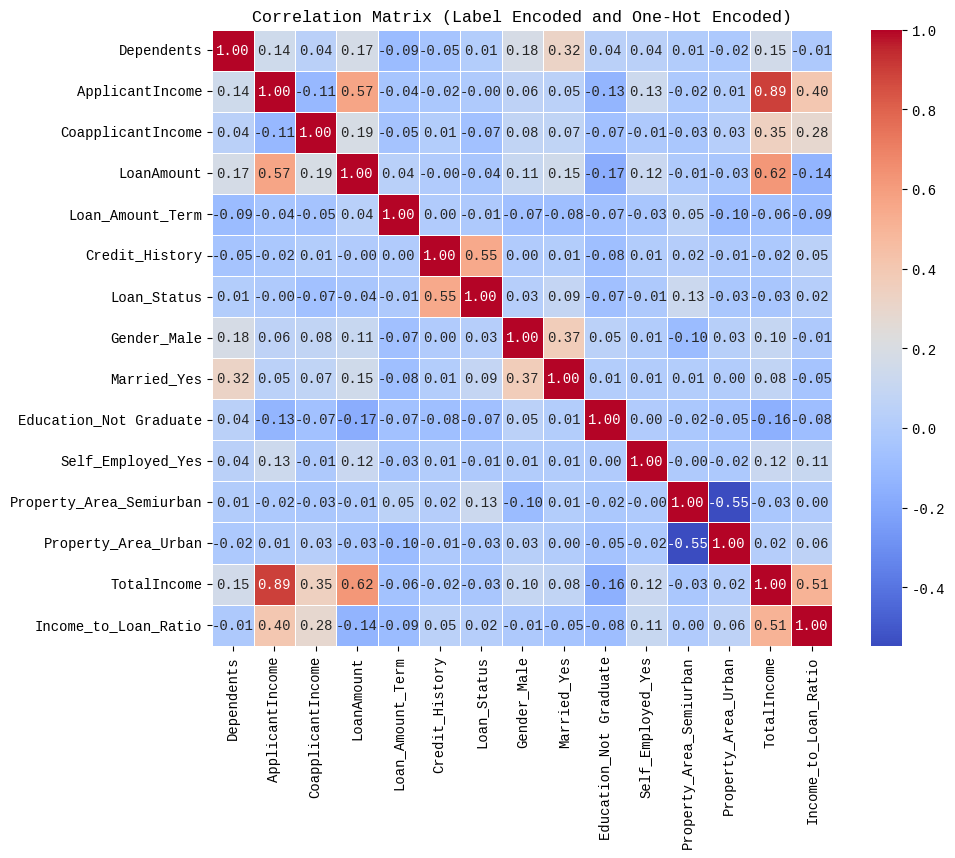

In [ ]:
train_cleaned.drop(columns=['Loan_ID'], inplace=True)
train_cleaned['Dependents'] = train_cleaned['Dependents'].replace('3+', 4)

# 라벨 인코딩된 데이터의 상관관계 분석
plt.figure(figsize=(10, 8))
sns.heatmap(train_cleaned.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Label Encoded and One-Hot Encoded)")
plt.show()

# 가설검정

## 독립 표본 t-검정

H0:기혼자는 대출 금액이 높지 않을 것이다.(기혼자와 비기혼자의 대출 금액 차이가 없다.)\
H1:기혼자는 대출 금액이 높을 것이다.(기혼자의 대출 금액이 비기혼자보다 크다.)

In [ ]:
import scipy.stats as stats

# 기혼자와 비기혼자의 대출 금액 추출
married = train[train['Married'] == 'Yes']['LoanAmount']
not_married = train[train['Married'] == 'No']['LoanAmount']

# 독립 표본 t-검정 수행
t_stat, p_value = stats.ttest_ind(married, not_married, nan_policy='omit')

# 결과 출력
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# 가설 검정 결과
alpha = 0.05  # 유의수준 0.05

if p_value < alpha:
    print("귀무가설을 기각합니다. 기혼자가 대출 금액이 높다는 대립가설을 채택합니다.")
else:
    print("귀무가설을 기각할 수 없습니다. 기혼자가 대출 금액이 높지 않다는 귀무가설을 유지합니다.")

T-statistic: 3.678722409807056
P-value: 0.00025584311633020703
귀무가설을 기각합니다. 기혼자가 대출 금액이 높다는 대립가설을 채택합니다.


H0:남성은 여성에 비해 대출 금액이 높지 않을 것이다.\
H1:남성은 여성에 비해 대출 금액이 높을 것이다.

In [ ]:
import scipy.stats as stats

# 남성(Male)과 여성(Female)의 대출 금액 추출
male = train[train['Gender'] == 'Male']['LoanAmount']
female = train[train['Gender'] == 'Female']['LoanAmount']

# 독립 표본 t-검정 수행
t_stat, p_value = stats.ttest_ind(male, female, nan_policy='omit')

# 결과 출력
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# 가설 검정 결과
alpha = 0.05  # 유의수준 0.05

if p_value < alpha:
    print("귀무가설을 기각합니다. 남성이 여성에 비해 대출 금액이 높다는 대립가설을 채택합니다.")
else:
    print("귀무가설을 기각할 수 없습니다. 남성이 여성에 비해 대출 금액이 높지 않다는 귀무가설을 유지합니다.")

T-statistic: 2.6763233198553484
P-value: 0.007650337096647051
귀무가설을 기각합니다. 남성이 여성에 비해 대출 금액이 높다는 대립가설을 채택합니다.


H0: 소득에 따른 대출 금액의 차이가 없다.\
H1: 소득에 따른 대출 금액의 차이가 있다.

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

# ApplicantIncome의 중앙값 계산
median_income = train['ApplicantIncome'].median()

# 중앙값을 기준으로 소득을 두 그룹으로 나누기
high_income_group = train[train['ApplicantIncome'] > median_income]  # 고소득 그룹
low_income_group = train[train['ApplicantIncome'] <= median_income]  # 저소득 그룹

# 각 그룹의 대출 금액 추출
high_income_loan_amount = high_income_group['LoanAmount']
low_income_loan_amount = low_income_group['LoanAmount']

# t-검정 수행
t_stat, p_value = ttest_ind(high_income_loan_amount, low_income_loan_amount, equal_var=False)

# p-value 출력
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# 가설 검정
alpha = 0.05  # 유의수준
if p_value < alpha:
    print("귀무가설을 기각합니다. 소득에 따라 대출 금액에 차이가 있습니다.")
else:
    print("귀무가설을 기각할 수 없습니다. 소득에 따라 대출 금액에 차이가 없습니다.")

t-statistic: 10.05920187225431, p-value: 2.4665270318322658e-21
귀무가설을 기각합니다. 소득에 따라 대출 금액에 차이가 있습니다.


## 카이제곱 검정

H0:성별에 따라 대출 승인 여부의 차이가 없다.\
H1:성별에 따라 대출 승인 여부의 차이가 있다.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# 성별과 대출 승인 여부의 교차표 생성
contingency_table = pd.crosstab(train['Gender'], train['Loan_Status'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(contingency_table)

# p-value 출력
print(f"p-value: {p}")

# 가설 검정
alpha = 0.05  # 유의수준
if p < alpha:
    print("귀무가설을 기각합니다. 성별에 따른 대출 승인 여부에 차이가 있습니다.")
else:
    print("귀무가설을 기각할 수 없습니다. 성별에 따른 대출 승인 여부에 차이가 없습니다.")

p-value: 0.6168136614066205
귀무가설을 기각할 수 없습니다. 성별에 따른 대출 승인 여부에 차이가 없습니다.


H0:신용기록 여부에 따라 대출 승인 여부의 차이가 없다.\
H1:신용기록 여부에 따라 대출 승인 여부의 차이가 있다.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# 신용기록 여부와 대출 승인 여부의 교차표 생성
contingency_table = pd.crosstab(train['Credit_History'], train['Loan_Status'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(contingency_table)

# p-value 출력
print(f"p-value: {p}")

# 가설 검정
alpha = 0.05  # 유의수준
if p < alpha:
    print("귀무가설을 기각합니다. 신용기록 여부에 따라 대출 승인 여부에 차이가 있습니다.")
else:
    print("귀무가설을 기각할 수 없습니다. 신용기록 여부에 따라 대출 승인 여부에 차이가 없습니다.")

p-value: 7.039586187855029e-40
귀무가설을 기각합니다. 신용기록 여부에 따라 대출 승인 여부에 차이가 있습니다.


# 클러스터링

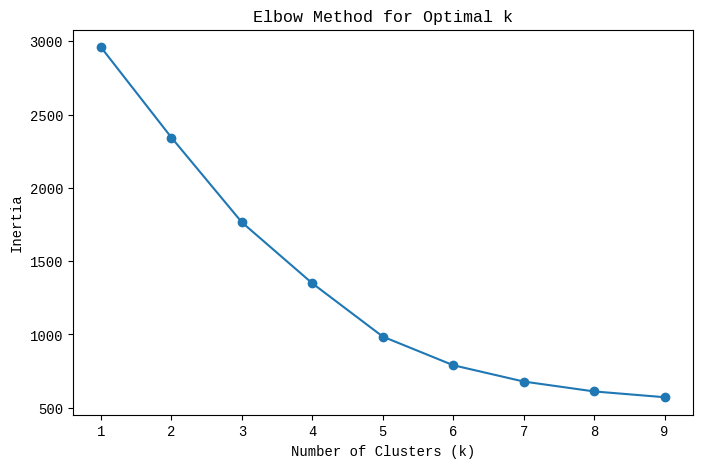

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

num_features = ["TotalIncome", "Income_to_Loan_Ratio", "LoanAmount", "Loan_Amount_Term", "Credit_History"]

X = pd.concat([train[num_features]], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate inertia for different values of k
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

최적의 클러스터 개수: 5


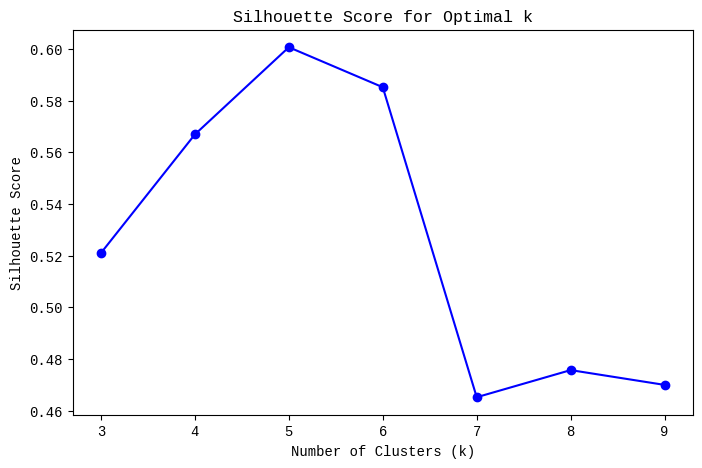

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# 클러스터 개수 후보
k_values = range(3, 10)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)  # 데이터는 정규화된 걸로 사용
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)

# 최적의 k 찾기
best_k = k_values[np.argmax(silhouette_scores)]
print(f"최적의 클러스터 개수: {best_k}")

# 실루엣 스코어 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

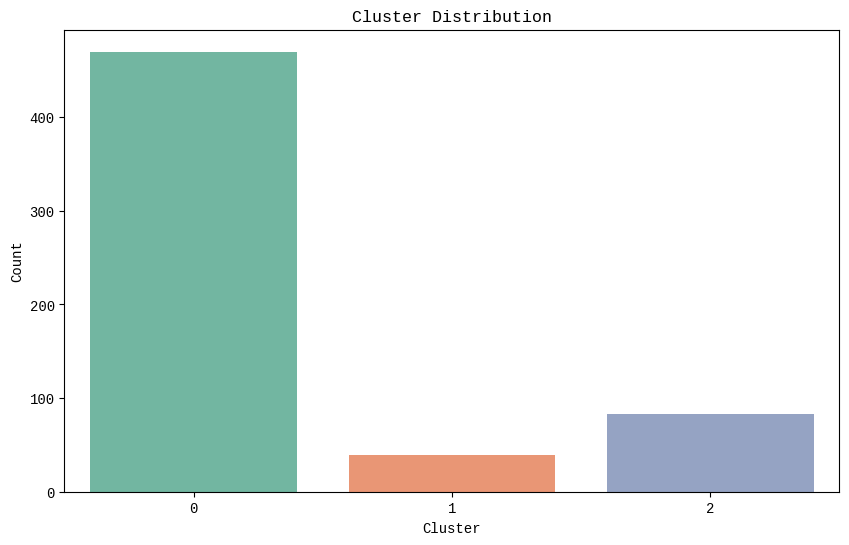

          TotalIncome  Income_to_Loan_Ratio  LoanAmount  Loan_Amount_Term  \
Cluster                                                                     
0         5768.389191             47.097997  133.312766        342.000000   
1        24880.974359            115.428776  330.128205        346.153846   
2         5907.060241             44.432532  134.265060        344.096386   

         Credit_History  
Cluster                  
0              1.000000  
1              0.923077  
2              0.000000  


In [ ]:
# 3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit KMeans on X_scaled and get cluster labels
cluster_labels = kmeans.fit_predict(X_scaled)

# Filter cluster labels to match the current size of train_df
cluster_labels_filtered = cluster_labels[:len(train)] # Select only the first 592 labels

# Assign the filtered cluster labels to the 'Cluster' column in train_df
train["Cluster"] = cluster_labels_filtered
# ----------------------------------------------------------

# 9. 클러스터별 특성 분석
plt.figure(figsize=(10, 6))
sns.countplot(x="Cluster", data=train, palette="Set2")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Distribution")
plt.show()

# 클러스터별 평균값 비교
cluster_means = train.groupby("Cluster")[num_features].mean()
print(cluster_means)

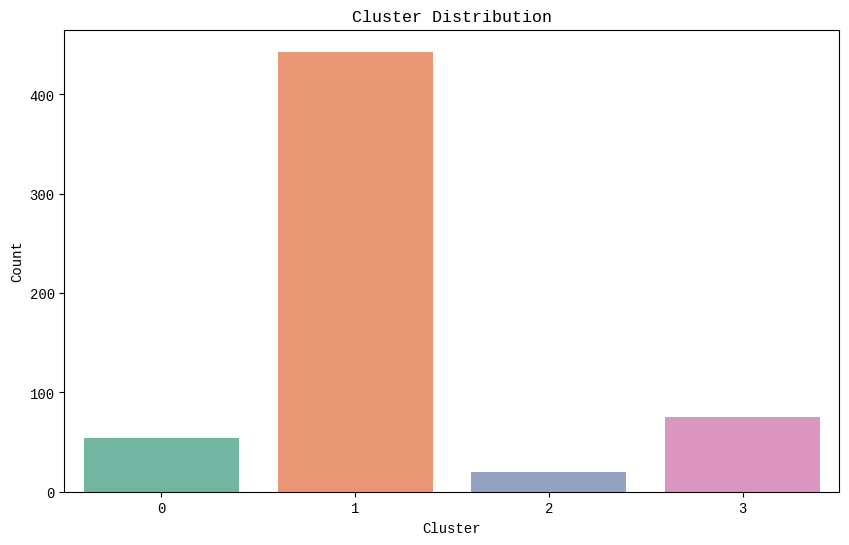

          TotalIncome  Income_to_Loan_Ratio  LoanAmount  Loan_Amount_Term  \
Cluster                                                                     
0         6216.848148             60.450996  117.277778        160.000000   
1         6283.575892             44.668195  147.616253        361.760722   
2        30036.800000            202.402574  216.100000        330.000000   
3         6022.893333             43.003538  141.693333        364.000000   

         Credit_History  
Cluster                  
0              0.833333  
1              1.000000  
2              0.900000  
3              0.000000  


In [ ]:
# 4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit KMeans on X_scaled and get cluster labels
cluster_labels = kmeans.fit_predict(X_scaled)

# Filter cluster labels to match the current size of train_df
cluster_labels_filtered = cluster_labels[:len(train)] # Select only the first 592 labels

# Assign the filtered cluster labels to the 'Cluster' column in train_df
train["Cluster"] = cluster_labels_filtered
# ----------------------------------------------------------

# 9. 클러스터별 특성 분석
plt.figure(figsize=(10, 6))
sns.countplot(x="Cluster", data=train, palette="Set2")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Distribution")
plt.show()

# 클러스터별 평균값 비교
cluster_means = train.groupby("Cluster")[num_features].mean()
print(cluster_means)

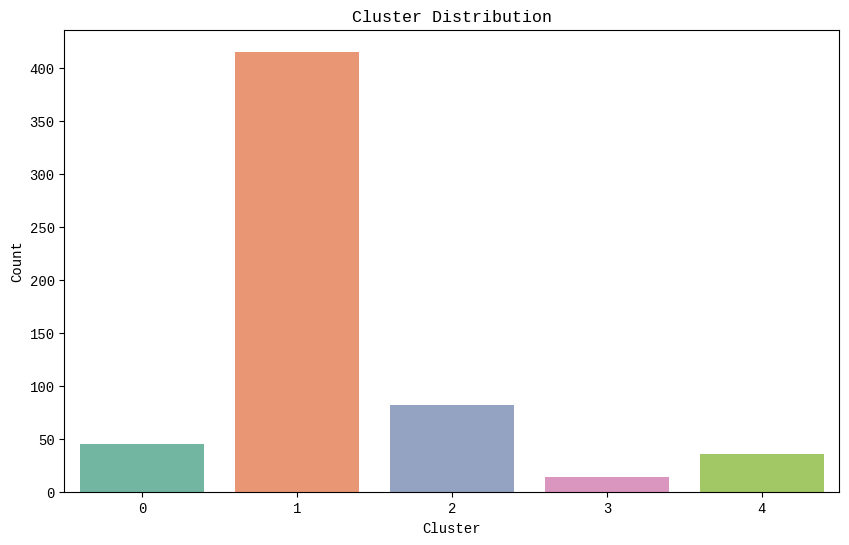

          TotalIncome  Income_to_Loan_Ratio  LoanAmount  Loan_Amount_Term  \
Cluster                                                                     
0         6229.440000             61.505495  118.244444        156.000000   
1         5632.713542             44.663115  132.214458        361.734940   
2         5812.646341             44.531703  131.317073        343.902439   
3        24443.428571            247.891029  103.000000        360.000000   
4        20417.805556             52.796305  396.555556        345.000000   

         Credit_History  
Cluster                  
0              1.000000  
1              1.000000  
2              0.000000  
3              0.928571  
4              0.916667  


In [ ]:
# 5
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit KMeans on X_scaled and get cluster labels
cluster_labels = kmeans.fit_predict(X_scaled)

# Filter cluster labels to match the current size of train_df
cluster_labels_filtered = cluster_labels[:len(train)] # Select only the first 592 labels

# Assign the filtered cluster labels to the 'Cluster' column in train_df
train["Cluster"] = cluster_labels_filtered
# ----------------------------------------------------------

# 9. 클러스터별 특성 분석
plt.figure(figsize=(10, 6))
sns.countplot(x="Cluster", data=train, palette="Set2")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Distribution")
plt.show()

# 클러스터별 평균값 비교
cluster_means = train.groupby("Cluster")[num_features].mean()
print(cluster_means)

# 클러스터 별 특징

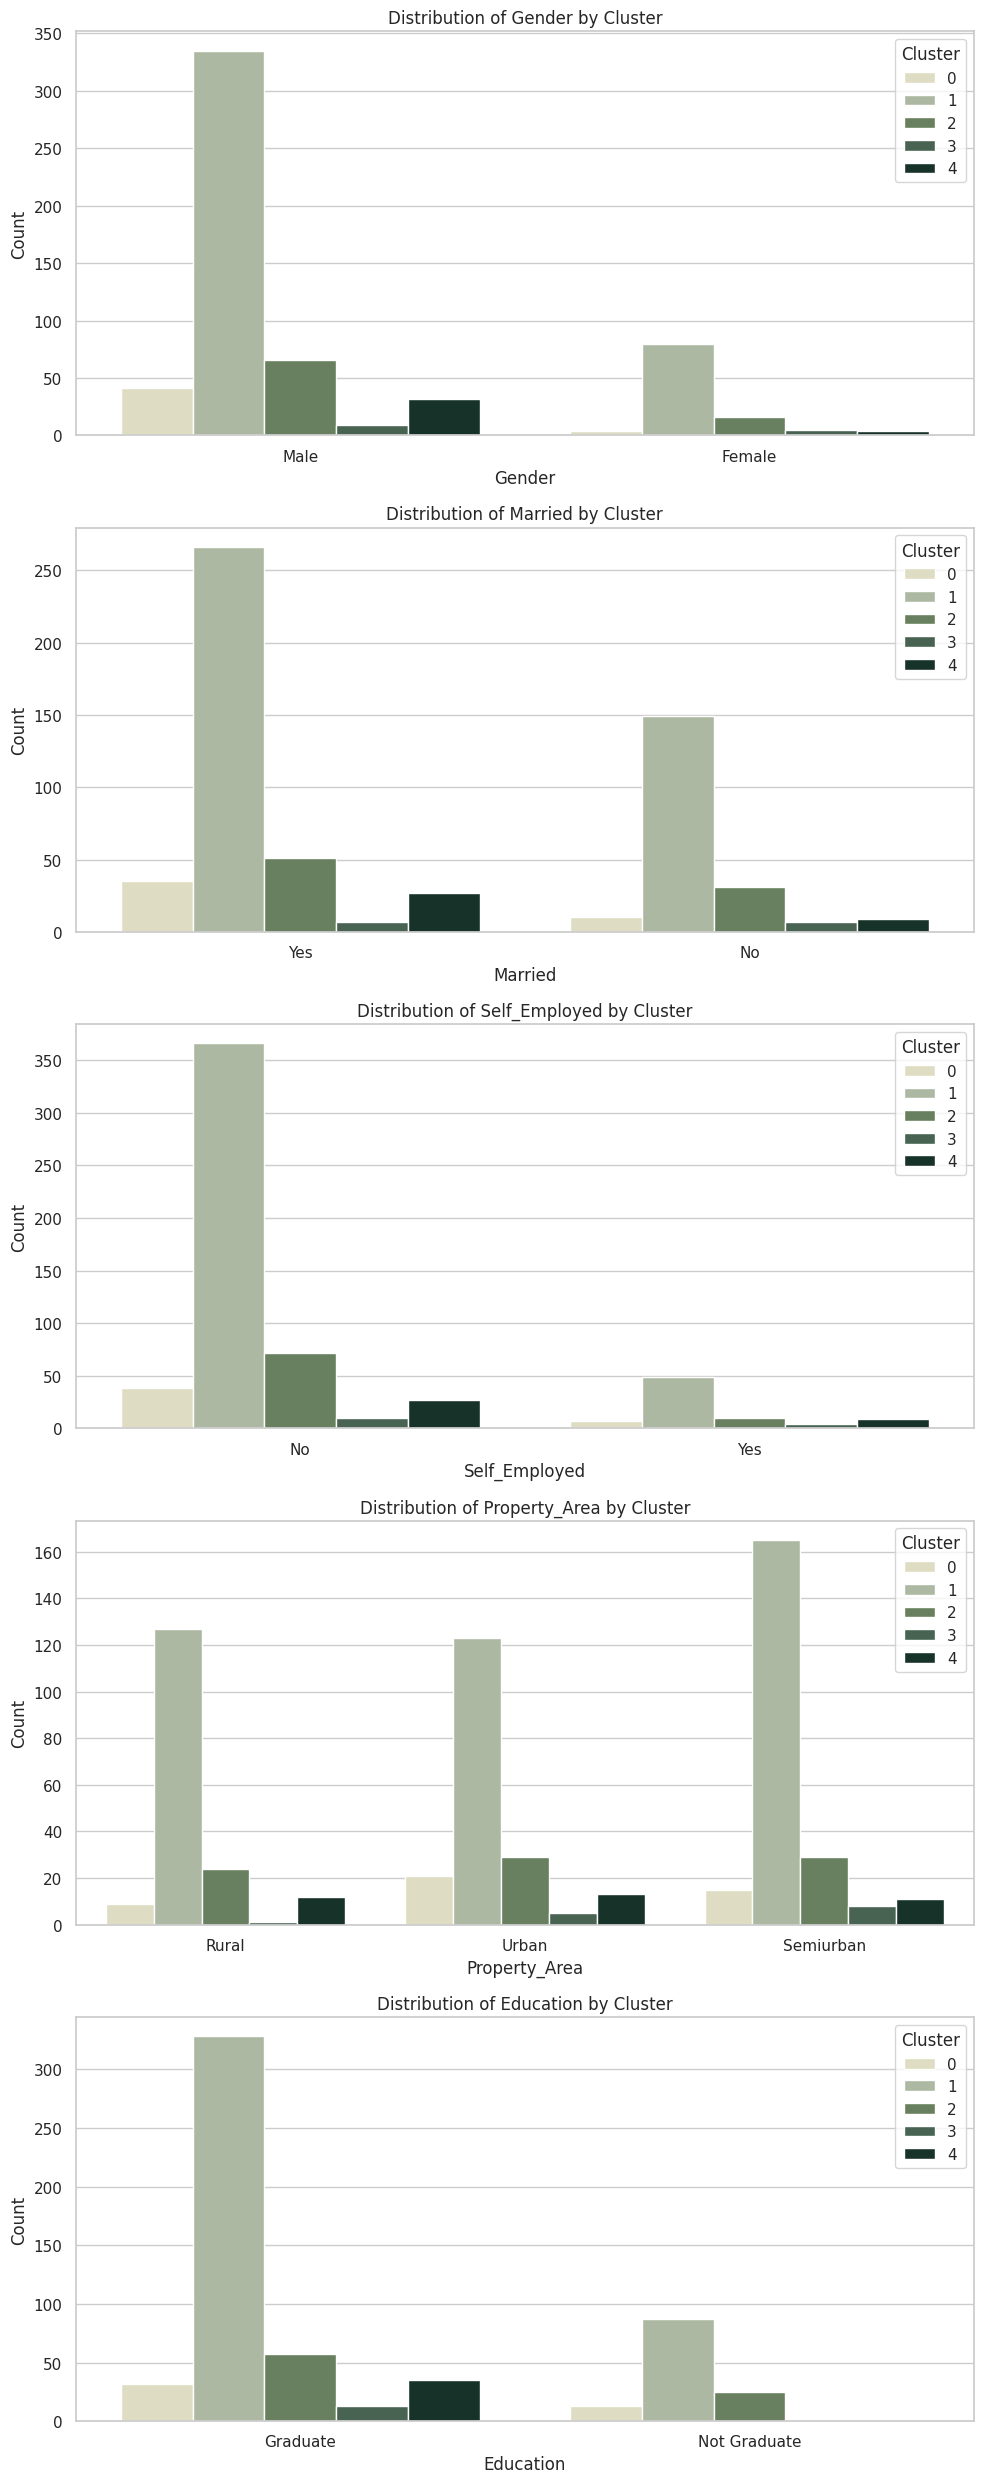

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 범주형 변수 리스트
cat_features = ['Gender', 'Married', 'Self_Employed', 'Property_Area', 'Education']

# 그래프 스타일 설정
sns.set(style="whitegrid")

# 원하는 그린 색상 팔레트 설정
custom_palette = sns.color_palette(["#e2e1bf", "#ADBC9F", "#66855a", "#436850", "#12372A"]) # '#' 추가

# 각 변수에 대해 클러스터별 분포를 그래프 형식으로 시각화
fig, axes = plt.subplots(len(cat_features), 1, figsize=(10, 5 * len(cat_features)))

# 그래프 그리기
for i, feature in enumerate(cat_features):
    ax = axes[i]
    # 각 범주형 변수에 대한 클러스터별 분포
    sns.countplot(data=train, x=feature, hue='Cluster', ax=ax, dodge=True, palette=custom_palette)
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

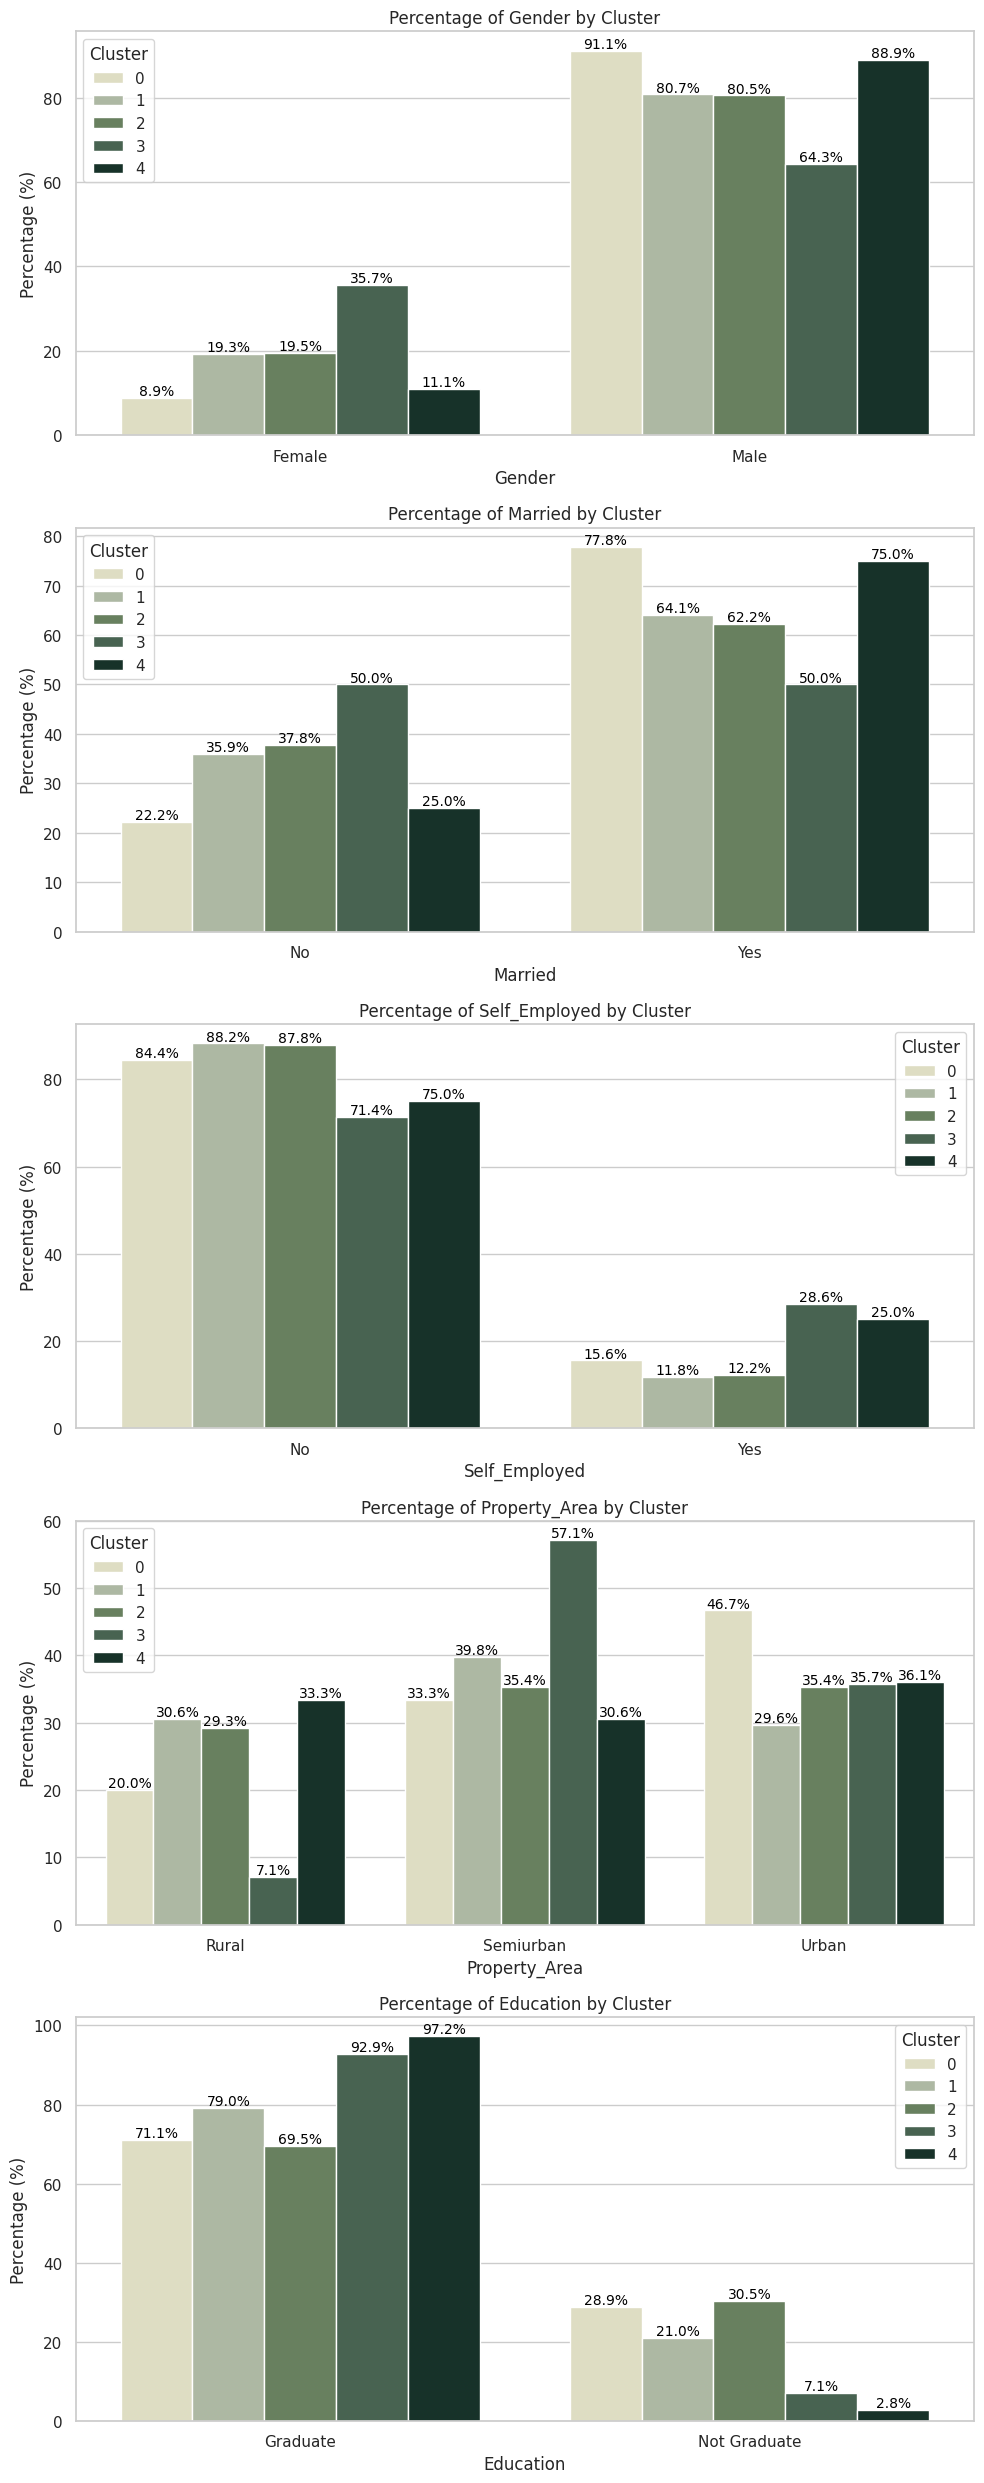

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 범주형 변수 리스트
cat_features = ['Gender', 'Married', 'Self_Employed', 'Property_Area', 'Education']

# 그래프 스타일 설정
sns.set(style="whitegrid")

# 원하는 색상 코드 리스트
custom_palette = ["#e2e1bf", "#ADBC9F", "#66855a", "#436850", "#12372A"]

# 각 변수에 대해 클러스터별 비율을 계산하고 시각화
fig, axes = plt.subplots(len(cat_features), 1, figsize=(10, 5 * len(cat_features)))

for i, feature in enumerate(cat_features):
    ax = axes[i]

    # 각 범주형 변수에 대해 클러스터별 비율 계산
    count_data = train.groupby(['Cluster', feature]).size().reset_index(name='count')
    total_counts = count_data.groupby('Cluster')['count'].transform('sum')  # 클러스터별 전체 샘플 수
    count_data['percentage'] = count_data['count'] / total_counts * 100  # 비율 계산

    # 비율을 바 차트로 그리기
    sns.barplot(data=count_data, x=feature, y='percentage', hue='Cluster', palette=custom_palette, ax=ax, dodge=True)

    ax.set_title(f'Percentage of {feature} by Cluster')
    ax.set_xlabel(feature)
    ax.set_ylabel('Percentage (%)')

    # 막대 위에 퍼센티지 텍스트 추가 (0%인 경우 제외)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # 비율이 0% 이상인 경우에만 텍스트 추가
            ax.annotate(f'{height:.1f}%',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center',
                        fontsize=10, color='black',
                        xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
train.to_csv('train_with_clusters.csv', index=False)

print("CSV 파일이 저장되었습니다.")

CSV 파일이 저장되었습니다.


# 모델링

In [ ]:
train_cleaned

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,Income_to_Loan_Ratio
1,1,4583,1508.0,128.0,8,1,0,True,True,False,False,False,False,6091.0,47.585938
2,0,3000,0.0,66.0,8,1,1,True,True,False,True,False,True,3000.0,45.454545
3,0,2583,2358.0,120.0,8,1,1,True,True,True,False,False,True,4941.0,41.175000
4,0,6000,0.0,141.0,8,1,1,True,False,False,False,False,True,6000.0,42.553191
5,2,5417,4196.0,267.0,8,1,1,True,True,False,True,False,True,9613.0,36.003745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,2900,0.0,71.0,8,1,1,False,False,False,False,False,False,2900.0,40.845070
610,4,4106,0.0,40.0,5,1,1,True,True,False,False,False,False,4106.0,102.650000
611,1,8072,240.0,253.0,8,1,1,True,True,False,False,False,True,8312.0,32.853755
612,2,7583,0.0,187.0,8,1,1,True,True,False,False,False,True,7583.0,40.550802


In [ ]:
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,Income_to_Loan_Ratio,Cluster
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,47.585938,1
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,45.454545,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,41.175000,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,42.553191,1
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0,36.003745,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,2900.0,40.845070,1
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,4106.0,102.650000,0
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,8312.0,32.853755,1
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,7583.0,40.550802,1


## 다중공선성

In [ ]:
X

,TotalIncome,Income_to_Loan_Ratio,LoanAmount,Loan_Amount_Term,Credit_History
1,6091.0,47.585938,128.0,360.0,1.0
2,3000.0,45.454545,66.0,360.0,1.0
3,4941.0,41.175000,120.0,360.0,1.0
4,6000.0,42.553191,141.0,360.0,1.0
5,9613.0,36.003745,267.0,360.0,1.0
...,...,...,...,...,...
609,2900.0,40.845070,71.0,360.0,1.0
610,4106.0,102.650000,40.0,180.0,1.0
611,8312.0,32.853755,253.0,360.0,1.0
612,7583.0,40.550802,187.0,360.0,1.0


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# X: 이미 인코딩된 독립 변수들
# 상수항 추가
X2=X.copy()
X2.drop(columns=['Credit_History'], inplace=True)
X_with_const = sm.add_constant(X2)  # X 데이터프레임에 상수항 추가

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns  # X_with_const의 컬럼 이름 사용
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# 출력
print(vif_data)

               Variable        VIF
0                 const  38.481498
1           TotalIncome   4.088567
2  Income_to_Loan_Ratio   2.531634
3            LoanAmount   3.085149
4      Loan_Amount_Term   1.016902


## 모델

In [ ]:
train_cleaned

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,Income_to_Loan_Ratio
1,1,4583,1508.0,128.0,8,1,0,True,True,False,False,False,False,6091.0,47.585938
2,0,3000,0.0,66.0,8,1,1,True,True,False,True,False,True,3000.0,45.454545
3,0,2583,2358.0,120.0,8,1,1,True,True,True,False,False,True,4941.0,41.175000
4,0,6000,0.0,141.0,8,1,1,True,False,False,False,False,True,6000.0,42.553191
5,2,5417,4196.0,267.0,8,1,1,True,True,False,True,False,True,9613.0,36.003745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,2900,0.0,71.0,8,1,1,False,False,False,False,False,False,2900.0,40.845070
610,4,4106,0.0,40.0,5,1,1,True,True,False,False,False,False,4106.0,102.650000
611,1,8072,240.0,253.0,8,1,1,True,True,False,False,False,True,8312.0,32.853755
612,2,7583,0.0,187.0,8,1,1,True,True,False,False,False,True,7583.0,40.550802


In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 이름 바꾸기
X = train_cleaned.copy()  # 피처 변수
X.drop(columns=['Loan_Status'], inplace=True)

y = train['Loan_Status']  # 타깃 변수

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


### 랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 모델 초기화
rf = RandomForestClassifier(random_state=42, n_estimators=100)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200],           # 트리 개수
    'max_depth': [None, 10, 20],              # 최대 깊이 (None이면 자동 설정)
    'min_samples_split': [2, 5, 10],          # 최소 샘플 분할 개수
    'min_samples_leaf': [1, 2, 4],            # 리프 노드 최소 샘플 개수
    'max_features': ['sqrt', 'log2', None]    # 최대 사용할 특성 개수
}

# GridSearchCV 실행 (교차 검증 포함)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 최적의 모델로 예측
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# rain 정확도 계산
y_train_pred = best_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Test 정확도 계산
y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# 성능 출력
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 분류 보고서(Classification Report) 출력
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬(Confusion Matrix) 출력
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Train Accuracy: 0.9493
Test Accuracy: 0.8202

Classification Report:
              precision    recall  f1-score   support

           N       0.81      0.54      0.64        54
           Y       0.82      0.94      0.88       124

    accuracy                           0.82       178
   macro avg       0.81      0.74      0.76       178
weighted avg       0.82      0.82      0.81       178


Confusion Matrix:
[[ 29  25]
 [  7 117]]


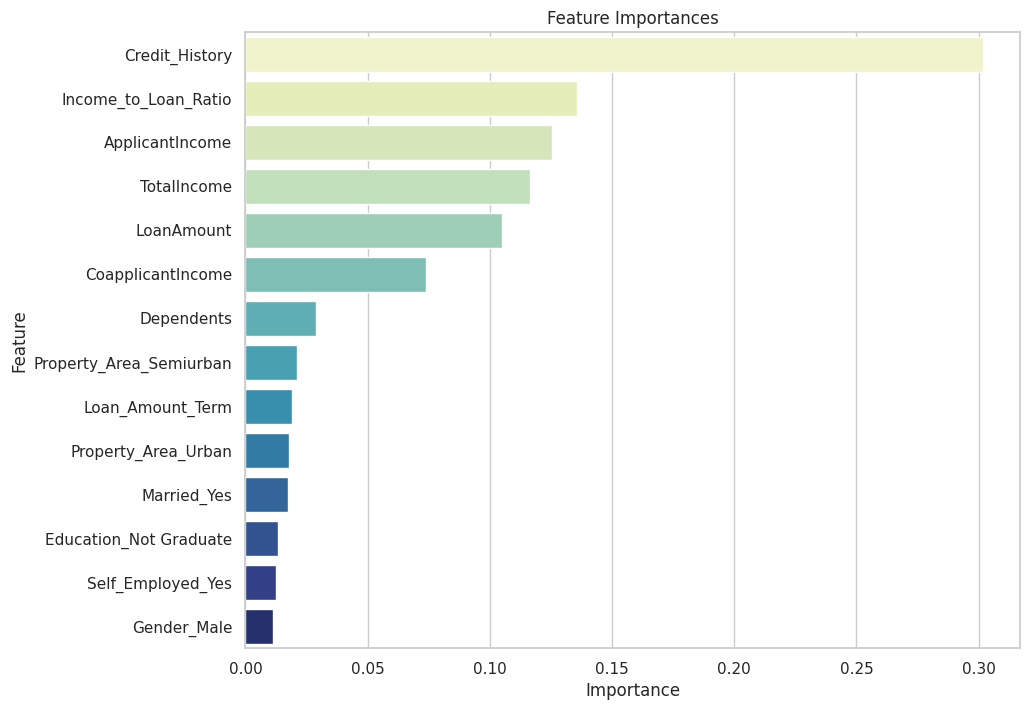

In [ ]:
# 특징 중요도 추출
feature_importances = best_rf.feature_importances_
features = X_train.columns

# 중요도 시각화
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# 중요도 순서로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='YlGnBu')
plt.title('Feature Importances')
plt.show()

In [ ]:
# 다시


rf = RandomForestClassifier(random_state=42, n_estimators=100)

param_grid = {
    'n_estimators': [50, 100, 200],                # 트리 개수
    'max_depth': [5, 10, 15],                   # 최대 깊이
    'min_samples_split': [10, 20],              # 최소 샘플 분할 개수
    'min_samples_leaf': [4, 6],                 # 리프 노드 최소 샘플 개수
    'max_features': ['sqrt', 'log2'],          # 최대 사용할 특성 개수
    'bootstrap': [True]                         # 부트스트랩 사용 여부
}

# GridSearchCV 실행 (교차 검증 포함)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 최적의 모델로 예측
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# rain 정확도 계산
y_train_pred = best_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Test 정확도 계산
y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# 성능 출력
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 분류 보고서(Classification Report) 출력
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬(Confusion Matrix) 출력
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 50}
Train Accuracy: 0.8333
Test Accuracy: 0.8315

Classification Report:
              precision    recall  f1-score   support

           N       0.93      0.48      0.63        54
           Y       0.81      0.98      0.89       124

    accuracy                           0.83       178
   macro avg       0.87      0.73      0.76       178
weighted avg       0.85      0.83      0.81       178


Confusion Matrix:
[[ 26  28]
 [  2 122]]


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

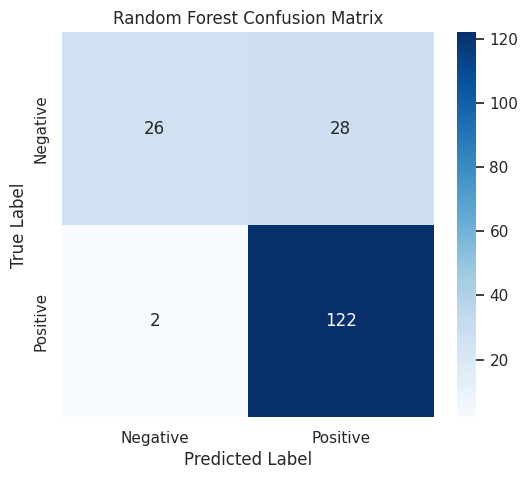

In [ ]:
# Confusion Matrix 데이터
conf_matrix = np.array([[26, 28],
                        [2, 122]])

# 클래스 라벨 정의
class_labels = ["Negative", "Positive"]

# 시각화
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# 그래프 제목 및 라벨 추가
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")

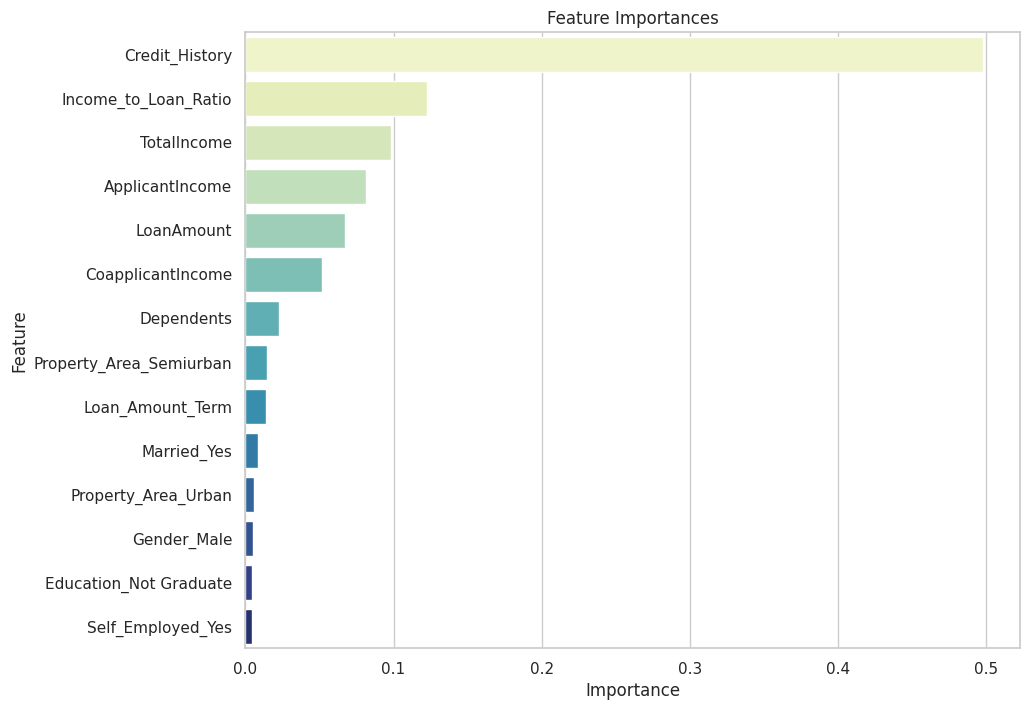

In [ ]:
# 특징 중요도 추출
feature_importances = best_rf.feature_importances_
features = X_train.columns

# 중요도 시각화
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# 중요도 순서로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='YlGnBu')
plt.title('Feature Importances')
plt.show()

### lightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Convert 'Dependents' column to numerical before fitting
X_train['Dependents'] = pd.to_numeric(X_train['Dependents'], errors='coerce').fillna(0).astype(int)
X_test['Dependents'] = pd.to_numeric(X_test['Dependents'], errors='coerce').fillna(0).astype(int)


# LGBM 모델 객체 생성
lgb_clf = lgb.LGBMClassifier(objective='binary', metric='binary_error')

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'min_data_in_leaf': [10, 20, 30],
    'lambda_l1': [0, 0.1, 0.5],
    'lambda_l2': [0, 0.1, 0.5]
}

# ridSearchCV 설정 (n_jobs=-1 → CPU 코어 다 사용)
grid_search = GridSearchCV(lgb_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Grid Search 수행
# early_stopping_rounds를 fit() 메서드의 파라미터에서 제거하고,
# callbacks=[lgb.early_stopping(50)]으로 변경, verbose를 콜백 안으로 이동
grid_search.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='binary_error',
                callbacks=[lgb.early_stopping(50, verbose=True)],  # verbose를 콜백 안으로 이동
                )

# 최적 파라미터와 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# 최적 모델로 최종 평가
best_lgb = grid_search.best_estimator_
y_train_pred = best_lgb.predict(X_train)
y_test_pred = best_lgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 분류 보고서(Classification Report) 출력
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬(Confusion Matrix) 출력
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Number of positive: 287, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` t

Text(0.5, 1.0, 'Light GBM Confusion Matrix')

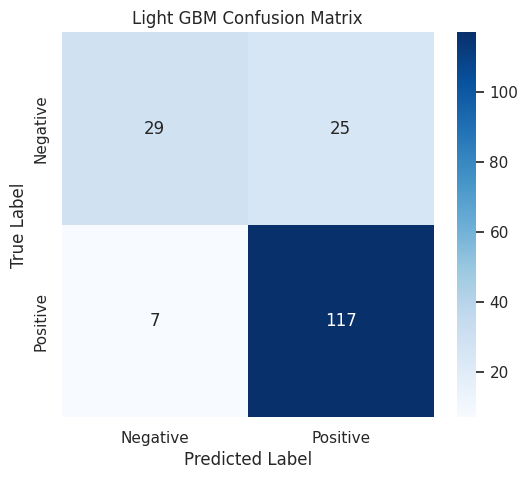

In [ ]:
# Confusion Matrix 데이터
conf_matrix = np.array([[29, 25],
                        [7, 117]])

# 클래스 라벨 정의
class_labels = ["Negative", "Positive"]

# 시각화
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# 그래프 제목 및 라벨 추가
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Light GBM Confusion Matrix")

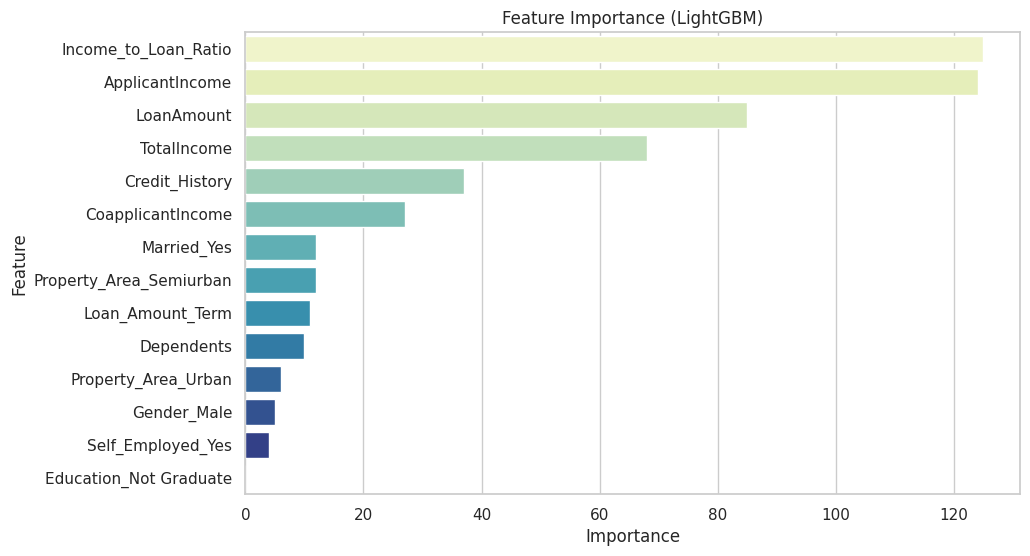

In [ ]:
# 특성 중요도 가져오기
feature_importance = best_lgb.feature_importances_
feature_names = X.columns

# DataFrame으로 변환
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="YlGnBu")
plt.title("Feature Importance (LightGBM)")
plt.show()